<a href="https://colab.research.google.com/github/aime-n/anomaly-detection-arima/blob/main/Aime_ConsultoriaEstatistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ler:<br>
[Introduction to Anomaly Detection in Python](https://blog.floydhub.com/introduction-to-anomaly-detection-in-python/)<br>
[Introduction to Anomaly Detection in Python: Techniques and Implementation](https://cnvrg.io/anomaly-detection-python/)<br>
[Simple Moving Average (SMA)](https://www.investopedia.com/terms/s/sma.asp)<br>
[A Comprehensive Guide to Time Series Analysis](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/)<br>
[The Complete Guide to Time Series Analysis and Forecasting](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)<br>
[Analysis of Time Series Data](https://medium.com/analytics-vidhya/analysis-of-time-series-data-dad4afa56358)<br>
[Achieving Stationarity with time series](https://towardsdatascience.com/achieving-stationarity-with-time-series-data-abd59fd8d5a0)

Referencias:<br>
[time-series-anomaly-detection-with-pycaret-](https://towardsdatascience.com/time-series-anomaly-detection-with-pycaret-706a6e2b2427)<br>
[pycaret docs](https://pycaret.gitbook.io/docs/get-started/tutorials)<br>

# Importações

## Bibliotecas

In [ ]:
# bibliotecas para manipulação e visualização
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats, pylab, datetime, holidays

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from pandas_datareader import data as wb
import plotly.express as px

In [ ]:
# !pip install python-bcb

In [ ]:
# from bcb import sgs

In [ ]:
# bibliotecas para modelo ARIMA e SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # para determinar (p,q)
from statsmodels.tsa.stattools import adfuller
from scipy.signal import argrelextrema

In [ ]:
!pip uninstall statsmodels -y pandas -y

Found existing installation: statsmodels 0.11.0
Uninstalling statsmodels-0.11.0:
  Successfully uninstalled statsmodels-0.11.0
Found existing installation: pandas 1.0.3
Uninstalling pandas-1.0.3:
  Successfully uninstalled pandas-1.0.3


In [ ]:
!pip install statsmodels===0.11.0 pandas===1.0.3
# Restart Runtime.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached statsmodels-0.11.0-cp37-cp37m-manylinux1_x86_64.whl (8.7 MB)
  Using cached pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl (10.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.20.2 requires pandas>=1.1, but you have pandas 1.0.3 which is incompatible.
google-colab 1.0.0 requires pandas>=1.1.0, but you have pandas 1.0.3 which is incompatible.
fbprophet 0.7.1 requires pandas>=1.0.4, but you have pandas 1.0.3 which is incompatible.


In [ ]:
!pip install pmdarima # restart runtime after it and run the imports again

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima import auto_arima # error if didnt restart runtime
import pmdarima as pm

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# !pip install ruptures
# import ruptures as rpt

In [ ]:
!pip install -U arimafd
import arimafd as oa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from bcb import sgs

## Funções

In [ ]:
axs = [
       (0,0),(0,1),(0,2),
       (1,0),(1,1),(1,2),
       (2,0),(2,1),(2,2)
]

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            # anomalies = pd.Series(np.nan, index=series.index)
            # anomalies[series<lower_bond] = series[series<lower_bond]
            # anomalies[series>upper_bond] = series[series>upper_bond]
            # plt.plot(anomalies, 'ro')


            anomalies = pd.DataFrame(index=series.index, 
                                     columns=series.columns,
                                     dtype=object)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [ ]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

In [ ]:
def column_to_datetime(df, columns, hour=False):
  for column in columns:
    if hour:
      df[column] = pd.to_datetime(df[column], format='%H:%M:%S').dt.time
    else:
      df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

  return df

In [ ]:
def br_feriados_():
    br_feriados = holidays.BR()  # this is a dict

    br_feriados = {datetime.date(2020, 11, 25): 'Black Friday',
                  datetime.date(2021, 11, 25): 'Black Friday',
                  datetime.date(2022, 11, 25): 'Black Friday'}
    for date in holidays.Brazil(years=[2020,2021,2022]).items():
        br_feriados[date[0]] = date[1]
    return br_feriados


def create_new_columns(df):
    ano, mes, dia, dia_semana, feriado = [], [], [], [], []

    for i in df['data_aprovacao_pedido']:
        data = pd.to_datetime(i)

        ano.append(data.year)
        mes.append(data.month)
        dia.append(data.day)
        dia_semana.append(data.weekday())

    names_columns = [
                     'ano_pedido', 
                     'mes_pedido', 
                     'dia_pedido',
                    'dia_da_semana_pedido', 
                     ]
    series_columns = [ano, 
                      mes, 
                      dia,
                      dia_semana, 
                      ]

    for name, serie in zip(names_columns, series_columns):
        df[name] = serie
        df[name] = df[name].astype('category')
    
    return df


def check_nulls(df):
    nulls = pd.DataFrame(data={
      'total nulls': df.isnull().sum(),
      'Porcentagem nulls': df.isnull().sum()/df.shape[0]
        })
    
    return nulls


def describe_id_seller(df, col):

    describe = pd.DataFrame()

    vendedores = df['id_seller'].unique()
    for vendedor in vendedores:
      df_vendedor = df[df['id_seller'] == vendedor]
      describe[vendedor] = df_vendedor[col].describe()
    
    return describe

In [ ]:
def get_bollinger_bands(prices, rate=10):
    sma = get_sma(prices, rate) # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

In [ ]:
def df_zeros(df: pd.DataFrame, 
             id_seller: str=None, 
             diff_: int=0, 
             ) -> pd.DataFrame:
    '''
    Essa função recebe a função original e acrescenta ...
    '''
    if id_seller is not None:
        df = df[df.id_seller == id_seller]
    
    min_ = df['data_aprovacao_pedido'].min()
    max_ = df['data_aprovacao_pedido'].max()
    datas_range = pd.date_range(min_, max_)

    df_original_mean = df.groupby('data_aprovacao_pedido').mean(
      )['preco_venda_item']
    datas_mean = df_original_mean.index
    precos_mean = df_original_mean.values
    precos_com_zeros = []

    c = 0
    for data in datas_range: # percorre todas datas, incluindo datas zeradas
        if data in datas_mean:
            precos_com_zeros.append(precos_mean[c])
            c+=1
        else:
            precos_com_zeros.append(0)
      
    df_zeros = pd.DataFrame()
    df_zeros['preco_venda_item'] = precos_com_zeros
    df_zeros.set_index(datas_range, inplace=True)

    if diff_ > 0:
        df_zeros = df_zeros.diff(diff_)
    
    return df_zeros


def dfz_per_id(df):
    dfz_ids = {}

    vendedores = df.id_seller.unique()
    for vendedor in vendedores:
        dfz_ids[vendedor] = df_zeros(df, id_seller=vendedor)

    return dfz_ids

In [ ]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [ ]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

In [ ]:
def return_arr(df, col):
    temp = [i for i in df[col]]
    temp = np.array(temp)

    return temp

In [ ]:
def multifig():
    fig, axs = plt.subplots(
                      ncols=3, nrows=3,
                      figsize=(20,15), 
                      sharex=True, 
                      sharey=True)
    
    return fig, axs

def multiplot(df, vendedores, dic_=False, scatter=False,
              dot=False):
    fig, axs = multifig()

    c = 0
    for i in range(3):
        for j in range(3):
          if dic_:
              data = df[vendedores[c]]
          else:
              data = df[df.id_seller == vendedores[c]]
          if scatter:
              axs[i, j].scatter(
                  x=data['mes_pedido'],
                  y=data['preco_venda_item']
              )
              axs[i, j].set_title(vendedores[c])
          if dot: # arrumar
              data.plot(style='.')
          else:
              axs[i, j].plot(data)
              axs[i, j].set_title(vendedores[c])
          c += 1

## Dados

In [ ]:
!git clone https://github.com/aime-n/anomaly-detection-arima

Cloning into 'anomaly-detection-arima'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 4), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [ ]:
df = pd.read_csv('/content/anomaly-detection-arima/dados_DeteccaoAnomalias.csv', sep=';', index_col=0, decimal=',')
df.head()

,id_seller,data_inclusao_item,data_aprovacao_pedido,qtde_itens_vendidos,preco_venda_item,hora_inclusao,hora_aprovacao
1,vendedor2,2021-07-16,2021-01-16,1,103.491893,15:25:53,17:03:00
2,vendedor2,2021-07-16,2021-01-16,1,103.516297,14:52:11,17:03:00
3,vendedor2,2021-07-16,2021-01-16,1,104.070149,14:33:30,17:03:00
4,vendedor2,2021-07-16,2021-01-16,1,103.337421,15:44:41,17:03:00
5,vendedor2,2016-12-08,2021-01-16,1,102.966221,13:00:36,17:03:00


# Descrição e manipulação do dataset

In [ ]:
print(f'Linhas: {df.shape[0]}')

Linhas: 131921


In [ ]:
df = column_to_datetime(df, ['hora_aprovacao', 'hora_inclusao'], hour=True)
df = column_to_datetime(df, ['data_aprovacao_pedido', 'data_inclusao_item'])

In [ ]:
df = create_new_columns(df) # ano, mes, dia, dia_semana

In [ ]:
feriados_br = br_feriados_()
df['feriados_pedidos'] = [feriados_br.get(i.date()) for i in df['data_aprovacao_pedido']]

In [ ]:
vendedores = df['id_seller'].unique()

In [ ]:
check_nulls(df)

,total nulls,Porcentagem nulls
id_seller,0,0.000000
data_inclusao_item,0,0.000000
data_aprovacao_pedido,14025,0.106314
qtde_itens_vendidos,0,0.000000
preco_venda_item,0,0.000000
hora_inclusao,0,0.000000
hora_aprovacao,14025,0.106314
ano_pedido,14025,0.106314
mes_pedido,14025,0.106314
dia_pedido,14025,0.106314


In [ ]:
df.data_aprovacao_pedido.describe()

count                  117896
unique                    258
top       2021-10-20 00:00:00
freq                     3275
first     2021-01-03 00:00:00
last      2022-02-18 00:00:00
Name: data_aprovacao_pedido, dtype: object

In [ ]:
df[df['preco_venda_item'] > 1200]['id_seller'].unique()

array(['vendedor4'], dtype=object)

In [ ]:
df.preco_venda_item.describe() # 1200 parece outlier

count    131921.000000
mean        209.072635
std         202.579897
min         100.386021
25%         124.571776
50%         157.906881
75%         200.349379
max        1201.799325
Name: preco_venda_item, dtype: float64

In [ ]:
df.qtde_itens_vendidos.describe()


count    131921.000000
mean          1.198710
std           0.845551
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          10.000000
Name: qtde_itens_vendidos, dtype: float64

In [ ]:
df.hora_inclusao.describe()

count       131921
unique        3668
top       14:41:18
freq          1645
Name: hora_inclusao, dtype: object

In [ ]:
df.hora_aprovacao.describe()

count       117896
unique         376
top       23:40:00
freq          3230
Name: hora_aprovacao, dtype: object

In [ ]:
df.data_inclusao_item.describe()

count                  131921
unique                    102
top       2021-07-16 00:00:00
freq                    24502
first     2015-12-08 00:00:00
last      2022-02-18 00:00:00
Name: data_inclusao_item, dtype: object

In [ ]:
df.describe()

,qtde_itens_vendidos,preco_venda_item
count,131921.000000,131921.000000
mean,1.198710,209.072635
std,0.845551,202.579897
min,1.000000,100.386021
25%,1.000000,124.571776
50%,1.000000,157.906881
75%,1.000000,200.349379
max,10.000000,1201.799325


In [ ]:
print('Describe da data de aprovacao do pedido por vendedor')
describe_id_seller(df, 'data_aprovacao_pedido')

Describe da data de aprovacao do pedido por vendedor


,vendedor2,vendedor8,vendedor9,vendedor4,vendedor1,vendedor5,vendedor3,vendedor6,vendedor7
count,11913,12160,13494,13110,11070,14212,13872,13125,14940
unique,19,35,64,21,175,17,20,15,12
top,2021-01-17 00:00:00,2021-11-11 00:00:00,2022-01-18 00:00:00,2021-12-27 00:00:00,2022-01-11 00:00:00,2021-10-20 00:00:00,2021-12-22 00:00:00,2021-05-26 00:00:00,2021-12-01 00:00:00
freq,2166,640,519,1140,270,3230,1224,875,1245
first,2021-01-12 00:00:00,2021-01-03 00:00:00,2021-01-05 00:00:00,2021-02-01 00:00:00,2021-01-04 00:00:00,2021-01-05 00:00:00,2021-12-11 00:00:00,2021-01-05 00:00:00,2021-09-29 00:00:00
last,2021-04-08 00:00:00,2022-02-15 00:00:00,2022-02-18 00:00:00,2022-02-16 00:00:00,2022-02-18 00:00:00,2022-01-04 00:00:00,2022-02-17 00:00:00,2021-12-09 00:00:00,2022-02-17 00:00:00


In [ ]:
print('Describe da data de inclusão do item por vendedor')
describe_id_seller(df, 'data_inclusao_item')

Describe da data de inclusão do item por vendedor


,vendedor2,vendedor8,vendedor9,vendedor4,vendedor1,vendedor5,vendedor3,vendedor6,vendedor7
count,13718,15360,15570,14820,13500,14858,14280,14875,14940
unique,34,32,4,12,7,2,4,6,7
top,2021-07-16 00:00:00,2021-10-07 00:00:00,2021-07-24 00:00:00,2021-10-14 00:00:00,2021-09-16 00:00:00,2021-10-04 00:00:00,2021-09-30 00:00:00,2021-07-16 00:00:00,2021-10-04 00:00:00
freq,11514,5376,14580,12506,11400,12788,7980,12988,4212
first,2015-12-08 00:00:00,2020-05-01 00:00:00,2021-07-24 00:00:00,2021-09-22 00:00:00,2020-10-24 00:00:00,2020-09-09 00:00:00,2021-09-13 00:00:00,2020-12-11 00:00:00,2021-09-23 00:00:00
last,2021-07-16 00:00:00,2022-02-18 00:00:00,2022-01-31 00:00:00,2022-01-28 00:00:00,2021-09-16 00:00:00,2021-10-04 00:00:00,2021-12-10 00:00:00,2021-08-17 00:00:00,2021-10-05 00:00:00


In [ ]:
# Onde falta data de aprovacao do pedido tambem falta hora da aprovacao
(df.data_aprovacao_pedido.isnull() == df.hora_aprovacao.isnull()).all()

True

### Acrescentando zeros


In [ ]:
dfz = df_zeros(df) # series com apenas preco_venda_item
dfz_ids = dfz_per_id(df)

# Análise Exploratória

## Análise Exploratória Univariada

In [ ]:
df.ano_pedido.unique()

[2021.0, 2022.0, NaN]
Categories (2, float64): [2021.0, 2022.0]

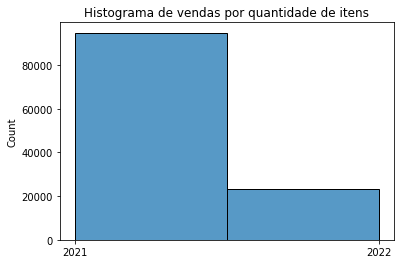

In [ ]:
plot_ = [int(ano) for ano in df.ano_pedido.dropna()]

fig = plt.figure()

sns.histplot(plot_, bins=2)
plt.xticks([2021,2022])
plt.title('Histograma de vendas por quantidade de itens')
fig.savefig('hist_vendas_ano_por_qtde_itens.png', dpi=fig.dpi)


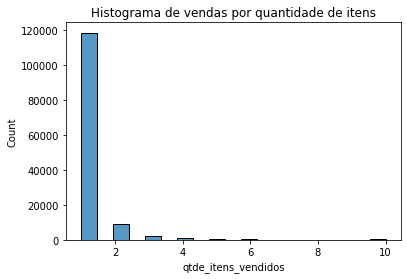

In [ ]:
fig = plt.figure()
sns.histplot(df['qtde_itens_vendidos'])
plt.title('Histograma de vendas por quantidade de itens')
fig.savefig('hist_vendas_por_qtde_itens.png', dpi=fig.dpi)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


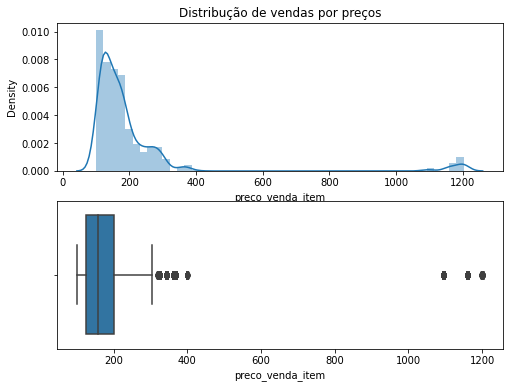

In [ ]:
fig, ax = plt.subplots(nrows=2)
fig.set_size_inches(8,6)

sns.distplot(df['preco_venda_item'], ax=ax[0])
ax[0].set_title('Distribução de vendas por preços')

sns.boxplot(x=df['preco_venda_item'], ax=ax[1])

fig.savefig('distr_vendas_por_preco.png', dpi=fig.dpi)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


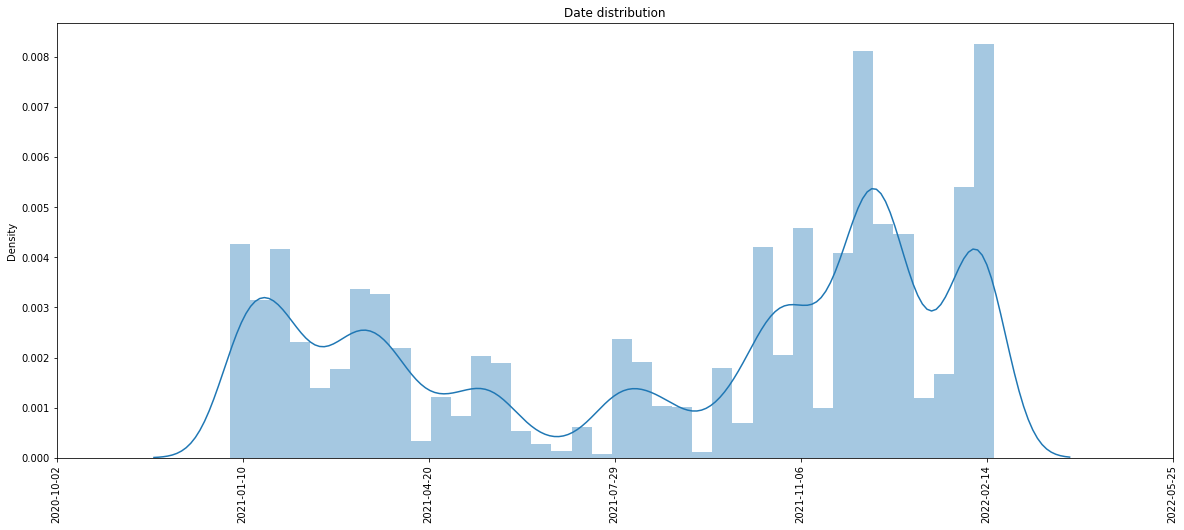

In [ ]:
# Go back to ordinal numbers...
ordinal_dates = np.array([d.toordinal() for d in df['data_aprovacao_pedido'].dropna() ])

fig = plt.figure(figsize=(20,8))
sns.distplot(ordinal_dates, kde=True)

# Now, get the positions of the xticks
ticks_locations, _ = plt.xticks();
# Get the labels for those positions
labels = [datetime.datetime.fromordinal(int(t)).date() for t in ticks_locations]

plt.xticks(ticks_locations, labels, rotation=90)
plt.title("Date distribution");

fig.savefig('date_distribution.png', dpi=fig.dpi)


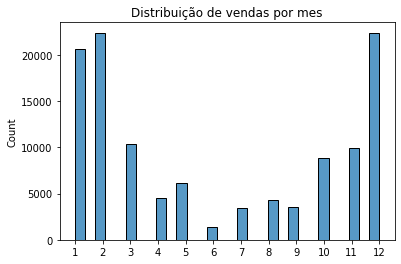

In [ ]:
fig = plt.figure()
ax = sns.histplot(return_arr(df, 'mes_pedido'))
plt.xticks(range(1,13))
plt.title('Distribuição de vendas por mes')

fig.savefig('distr_vendas_por_mes.png', dpi=fig.dpi)

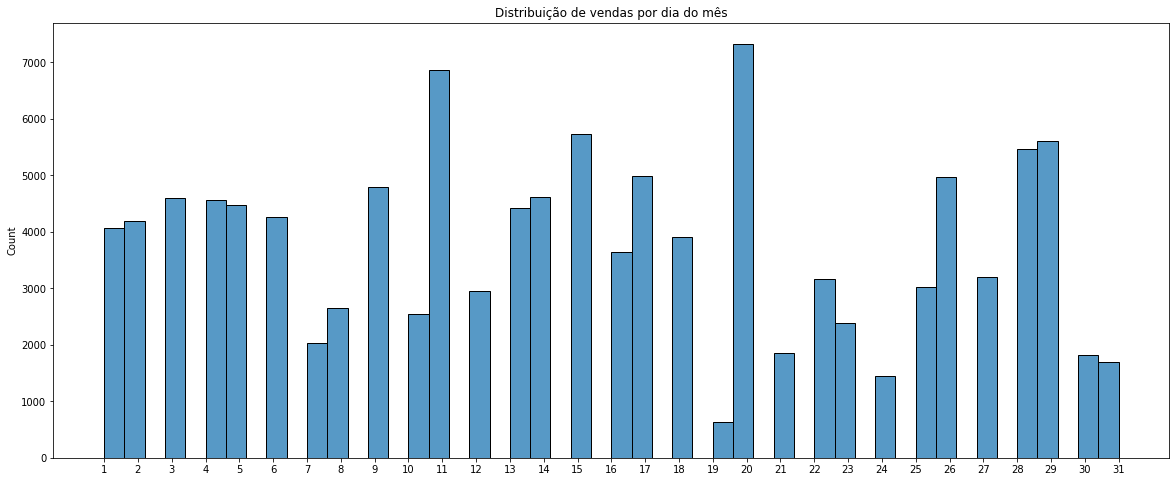

In [ ]:
fig = plt.figure(figsize=(20,8))

ax = sns.histplot(return_arr(df, 'dia_pedido'))
plt.xticks(range(1,32))
plt.title('Distribuição de vendas por dia do mês')

fig.savefig('distr_vendas_pordia_pormes.png', dpi=fig.dpi)

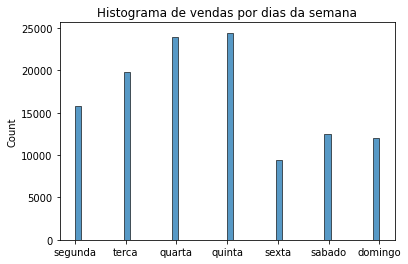

In [ ]:
fig = plt.figure()

ax = sns.histplot(x = return_arr(df, 'dia_da_semana_pedido')) # segunda == 0
a=ax.get_xticks().tolist()
a = ['-1','segunda', 'terca', 'quarta', 'quinta', 'sexta','sabado', 'domingo','7']
ax.set_xticklabels(a)
plt.title('Histograma de vendas por dias da semana')

fig.savefig('hist_vendas_pordias_dasemana.png', dpi=fig.dpi)

In [ ]:
df.columns

Index(['id_seller', 'data_inclusao_item', 'data_aprovacao_pedido',
       'qtde_itens_vendidos', 'preco_venda_item', 'hora_inclusao',
       'hora_aprovacao', 'ano_pedido', 'mes_pedido', 'dia_pedido',
       'dia_da_semana_pedido', 'feriados_pedidos'],
      dtype='object')

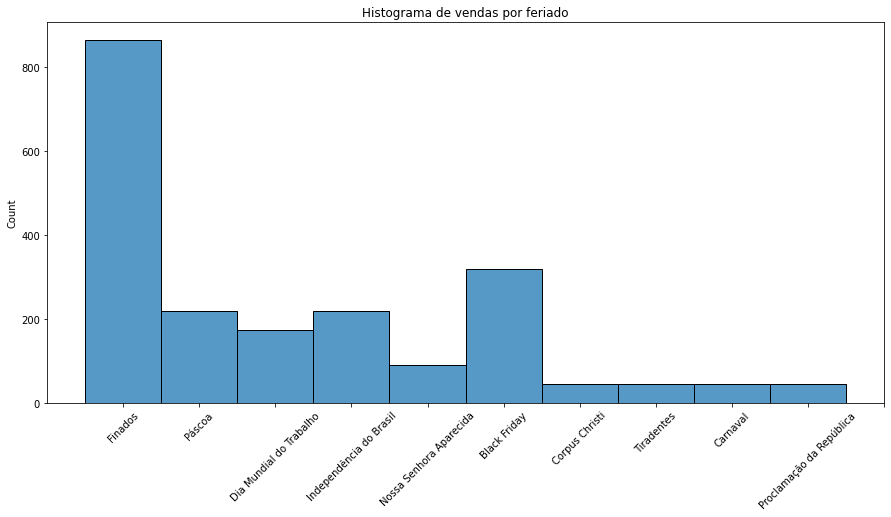

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15,7)

sns.histplot(return_arr(df, 'feriados_pedidos'), ax=ax)
plt.xticks(range(0, len(df['feriados_pedidos'].unique()) ))
plt.title('Histograma de vendas por feriado')

plt.xticks(rotation = 45)

fig.savefig('hist_vendasporferiado.png', dpi=fig.dpi)


In [ ]:
round(df.groupby('id_seller').describe(),3)

qtde_itens_vendidos                                          \
                        count   mean    std  min  25%  50%  75%   max   
id_seller                                                               
vendedor1             13500.0  1.053  0.266  1.0  1.0  1.0  1.0   3.0   
vendedor2             13718.0  1.158  0.586  1.0  1.0  1.0  1.0   4.0   
vendedor3             14280.0  1.057  0.232  1.0  1.0  1.0  1.0   2.0   
vendedor4             14820.0  1.000  0.000  1.0  1.0  1.0  1.0   1.0   
vendedor5             14858.0  1.826  2.057  1.0  1.0  1.0  2.0  10.0   
vendedor6             14875.0  1.294  0.570  1.0  1.0  1.0  1.0   3.0   
vendedor7             14940.0  1.167  0.373  1.0  1.0  1.0  1.0   2.0   
vendedor8             15360.0  1.208  0.815  1.0  1.0  1.0  1.0   5.0   
vendedor9             15570.0  1.011  0.105  1.0  1.0  1.0  1.0   2.0   

          preco_venda_item                                               \
                     count     mean      std      min      25%      50%   
id_seller                                                                 
vendedor1          13500.0  182.566   34.363  148.027  158.161  178.613   
vendedor2          13718.0  121.211   12.294  100.386  119.370  120.160   
vendedor3          14280.0  207.529   58.710  114.921  164.229  185.744   
vendedor4          14820.0  526.717  475.070  113.084  134.149  218.867   
vendedor5          14858.0  147.562   46.217  110.680  114.584  125.761   
vendedor6          14875.0  173.780   41.662  116.016  151.191  161.698   
vendedor7          14940.0  234.810   67.183  147.692  173.660  242.424   
vendedor8          15360.0  136.377   42.162  101.832  107.235  127.543   
vendedor9          15570.0  147.974   31.168  111.403  123.149  143.708   

                               
                75%       max  
id_seller                      
vendedor1   190.044   400.993  
vendedor2   122.149   180.977  
vendedor3   265.059   364.418  
vendedor4  1161.499  1201.799  
vendedor5   175.872   295.506  
vendedor6   175.919   274.966  
vendedor7   284.797   370.025  
vendedor8   130.330   281.601  
vendedor9   154.673   216.586

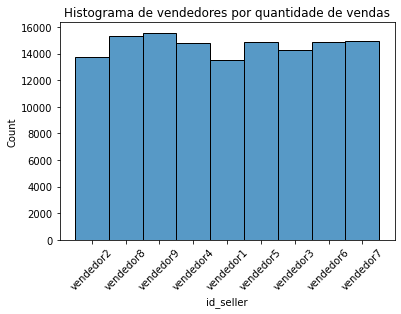

In [ ]:
fig = plt.figure()

sns.histplot(df['id_seller'])
plt.title('Histograma de vendedores por quantidade de vendas')
plt.xticks(rotation = 45)

fig.savefig('hist_vendedores_qte_itens.png', dpi=fig.dpi)


1         1610755200000000000
2         1610755200000000000
3         1610755200000000000
4         1610755200000000000
5         1610755200000000000
                 ...         
131917    1614470400000000000
131918    1614470400000000000
131919    1614470400000000000
131920    1614470400000000000
131921    1614470400000000000
Name: data_aprovacao_pedido, Length: 117896, dtype: int64


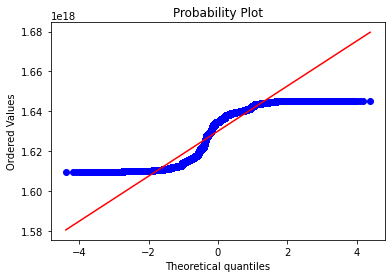

In [ ]:
data = pd.to_datetime(df['data_aprovacao_pedido']).dropna().astype(int)
print(data)
scipy.stats.probplot(data, plot=pylab)
pylab.show()

In [ ]:
## TODO: venda item contendo apenas feriados

In [ ]:
# TODO: grafico vendas por datas

## Análise exploratória de dados bivariados

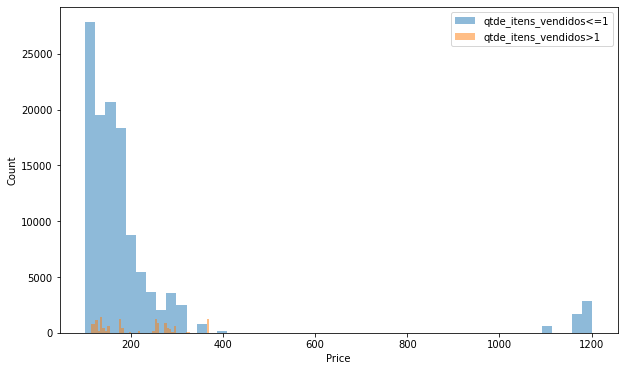

In [ ]:
a = df.loc[df['qtde_itens_vendidos'] <= 1, 'preco_venda_item']
b = df.loc[df['qtde_itens_vendidos'] > 1, 'preco_venda_item']

plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='qtde_itens_vendidos<=1')
plt.hist(b, bins = 50, alpha=0.5, label='qtde_itens_vendidos>1')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

Text(0.5, 1.0, 'Scatterplot do preço por cada vendedor')

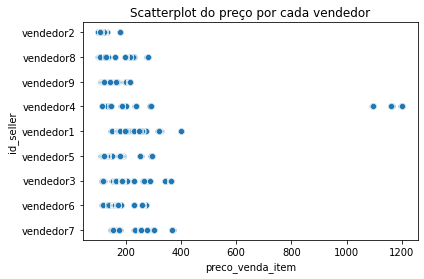

In [ ]:
plt.figure()
sns.scatterplot(data=df, x='preco_venda_item', y='id_seller')
plt.title('Scatterplot do preço por cada vendedor')

Text(0.5, 1.0, 'Boxplot do preço de cada vendedor')

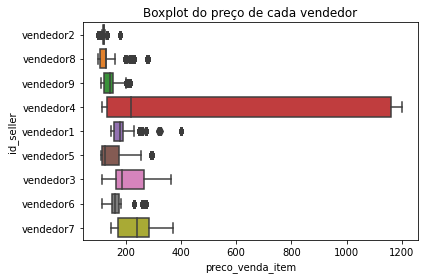

In [ ]:
plt.figure()
sns.boxplot(data=df, x='preco_venda_item', y='id_seller')
plt.title('Boxplot do preço de cada vendedor')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


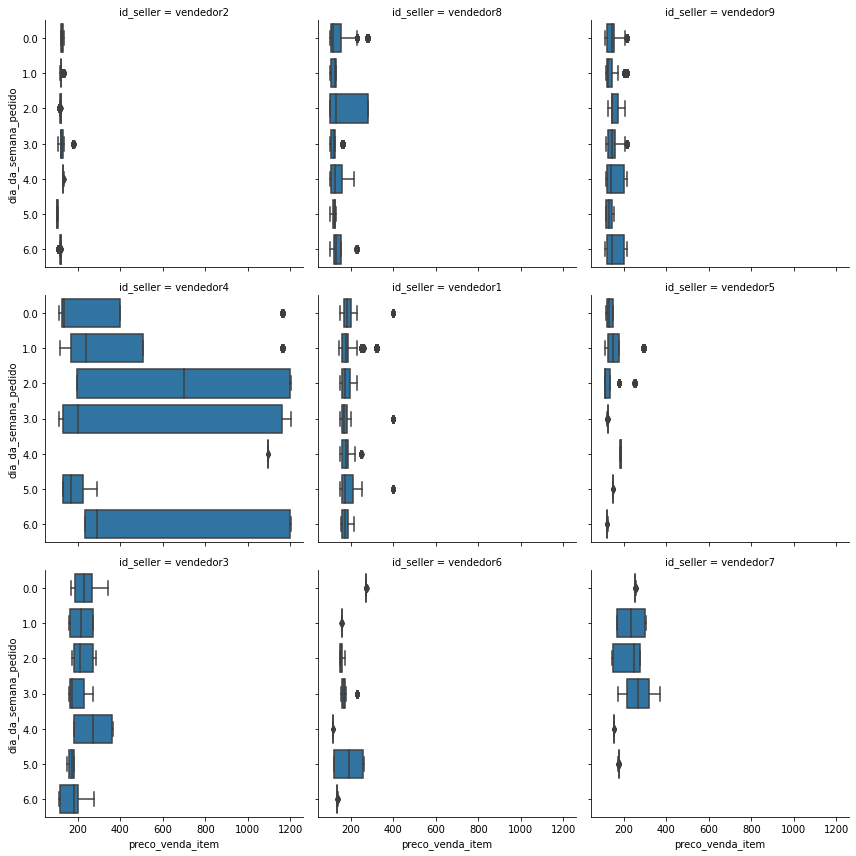

In [ ]:
g = sns.FacetGrid(df, col="id_seller", col_wrap=3, height=4, ylim=(0, 10))
g.map(sns.boxplot,'preco_venda_item', 'dia_da_semana_pedido')

g.savefig('3x3_boxplot.png')

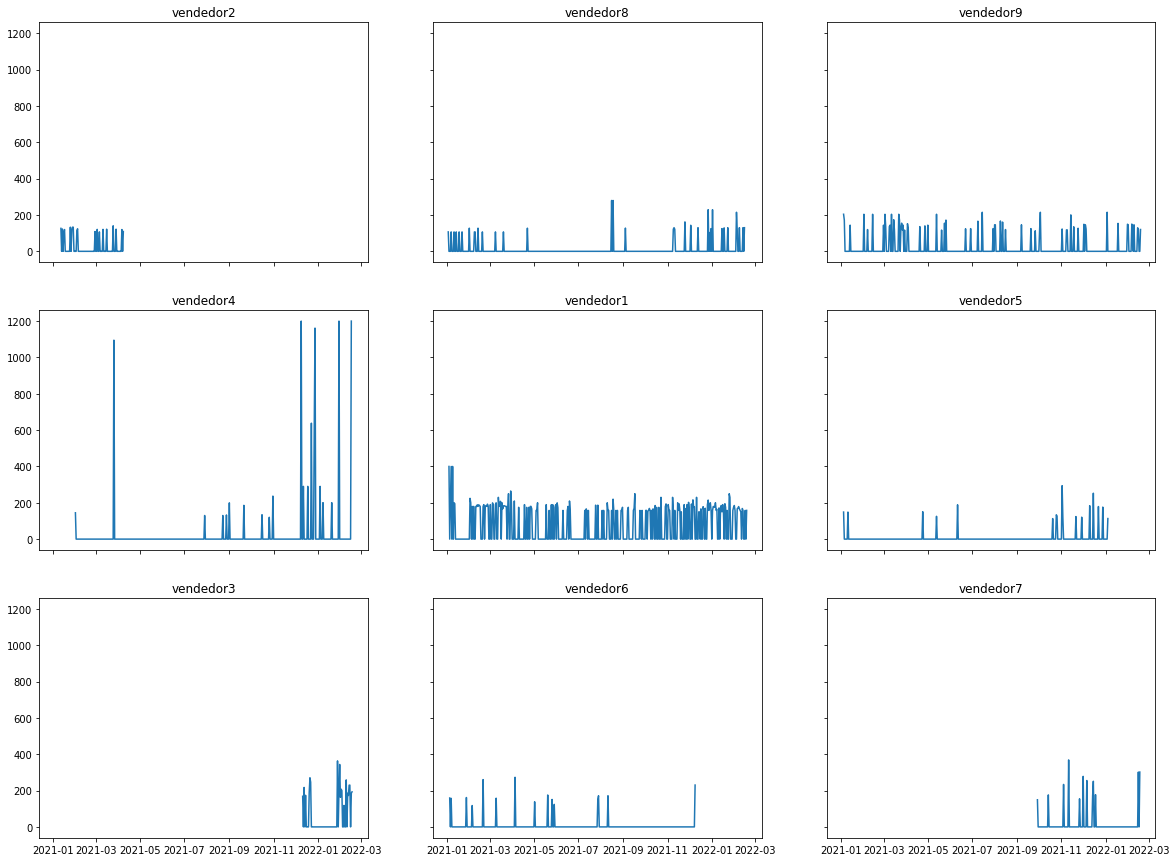

In [ ]:
multiplot(dfz_ids, vendedores, dic_=True)

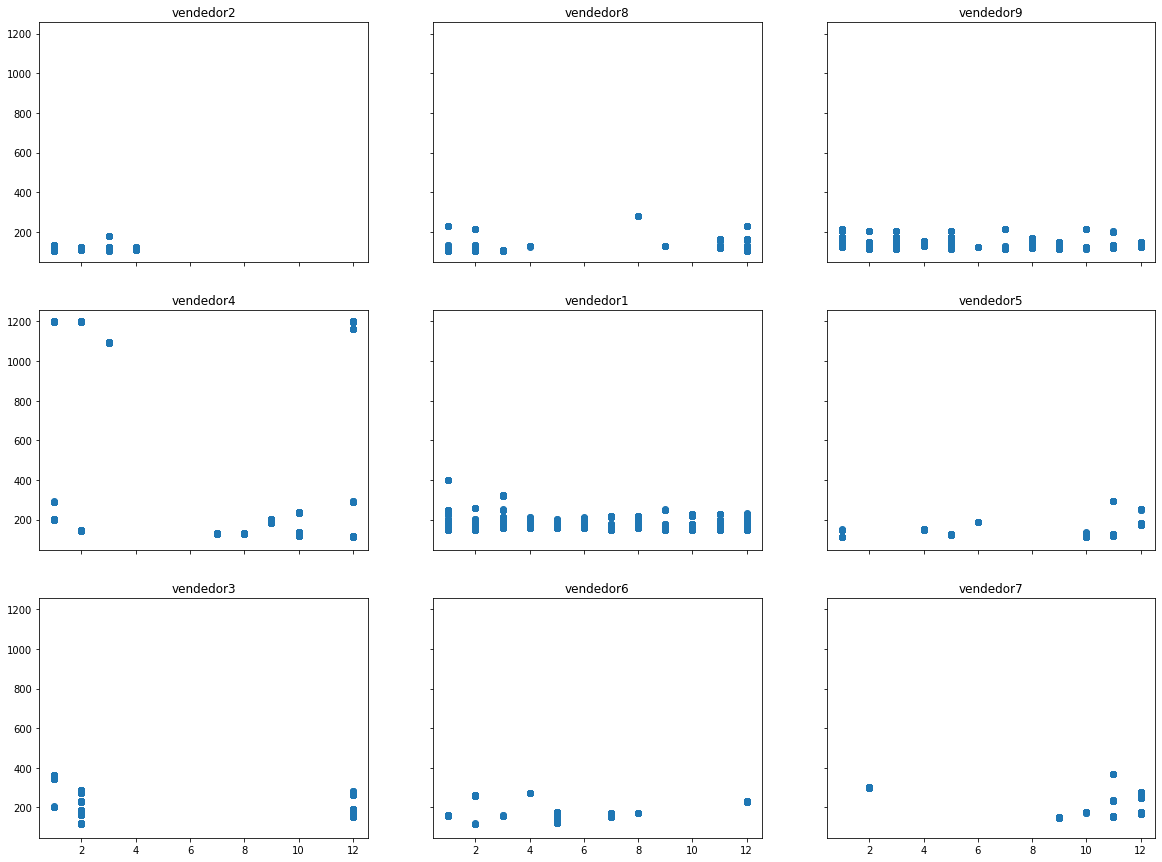

In [ ]:
multiplot(df, vendedores, scatter=True)

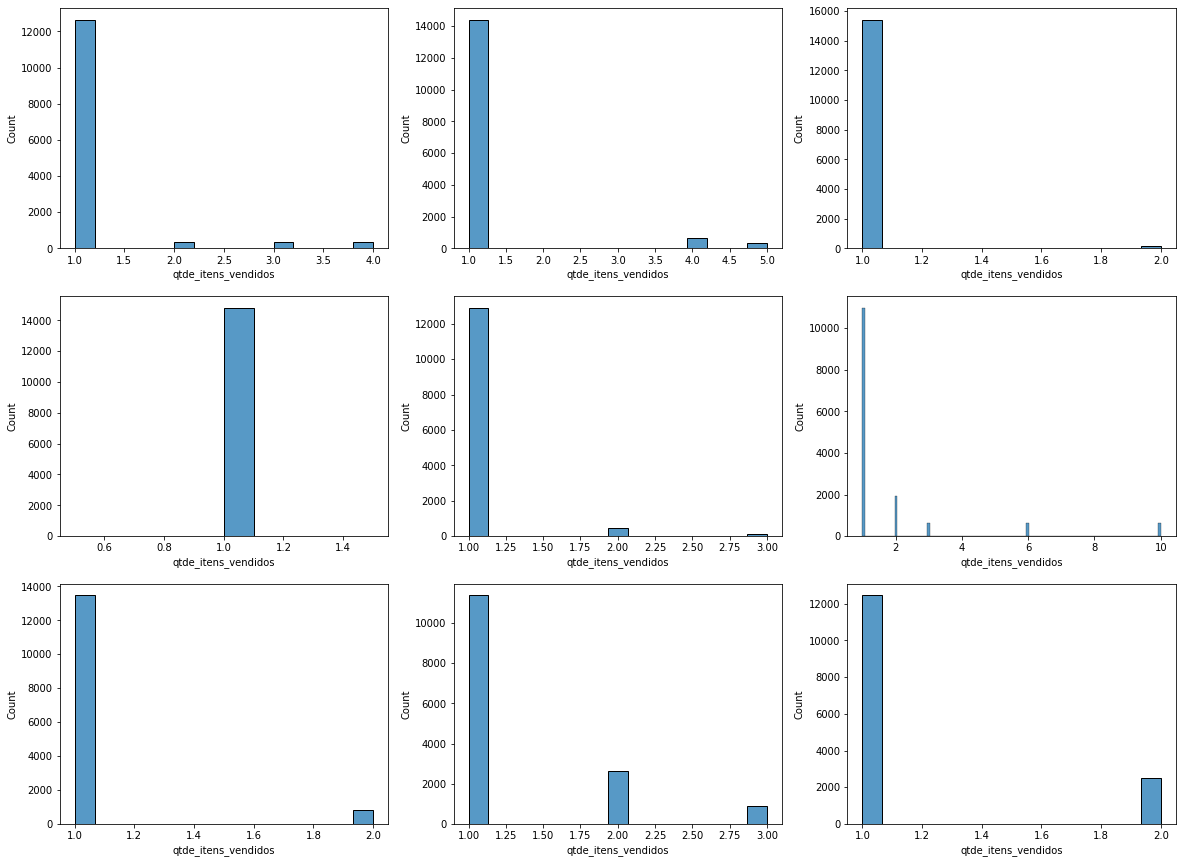

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,15))

for i in range(len(vendedores)):
  if i == 3:
    sns.histplot(data=df[df.id_seller == vendedores[i] ], bins=10,
              x='qtde_itens_vendidos',
            # x = 'dia_da_semana_pedido',
            # y = 'preco_venda_item',
            ax= ax[axs[i]])
    
  else:
    sns.histplot(data=df[df.id_seller == vendedores[i] ],
                x='qtde_itens_vendidos',
                # x = 'dia_da_semana_pedido',
                # y = 'preco_venda_item',
                ax= ax[axs[i]])
  # print(i)

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/usr/local/lib/python3.7/dist-packages/pandas/io/formats

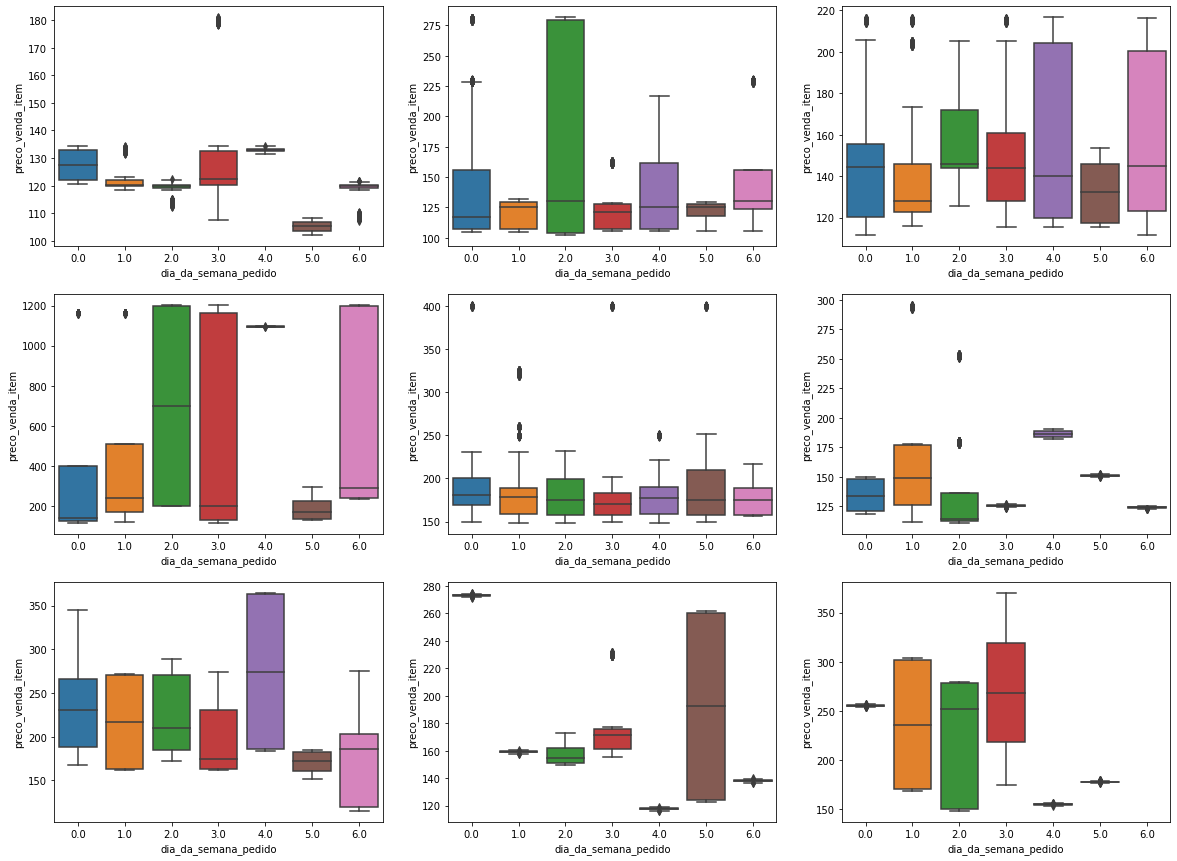

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,15))

for i in range(len(vendedores)):
  sns.boxplot(data=df[df.id_seller == vendedores[i] ],
              x = 'dia_da_semana_pedido',
              y = 'preco_venda_item',
              ax= ax[axs[i]])
  # print(i)

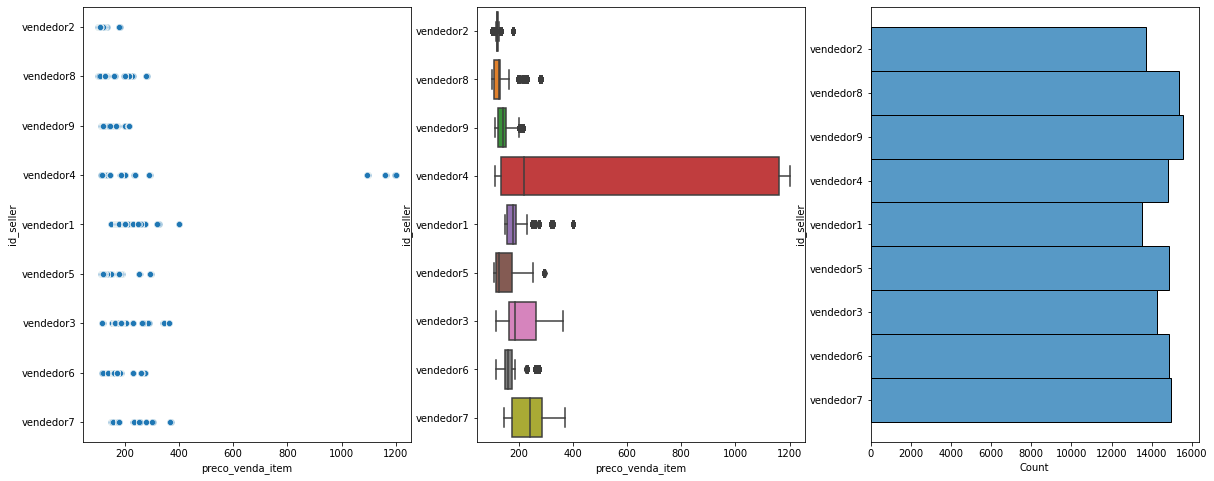

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize = (20,8))

sns.scatterplot(data=df, x='preco_venda_item', y='id_seller',ax=ax[0])
sns.boxplot(data=df, x='preco_venda_item', y='id_seller', ax=ax[1])
sns.histplot(data=df, y='id_seller', ax=ax[2])

# sns.histplot(x=df['dia_da_semana_pedido'],ax=ax[1,0])
# sns.boxplot(data=df, x='dia_da_semana_pedido', y='preco_venda_item', ax=ax[1,1])



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

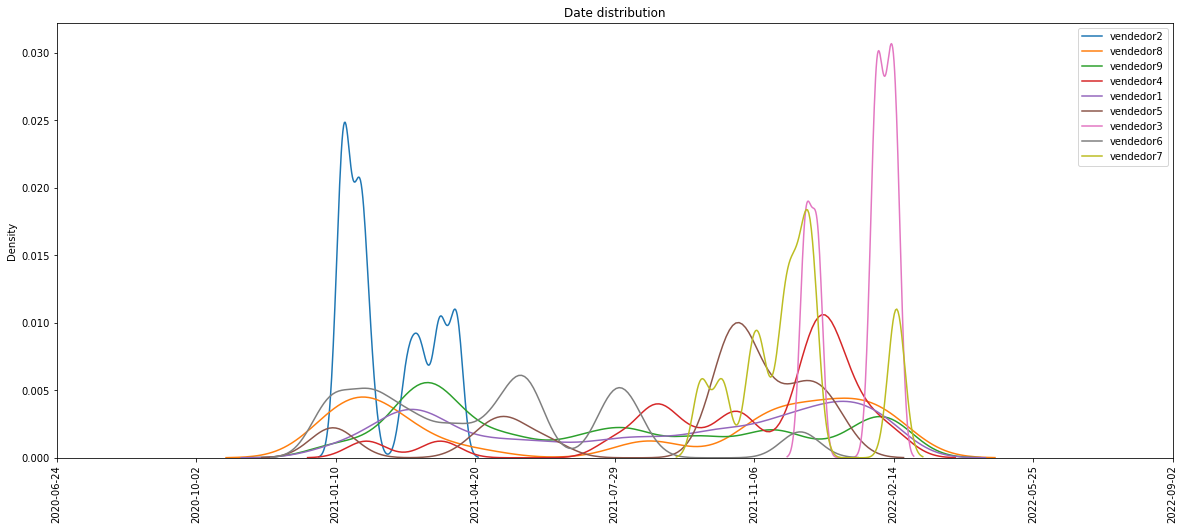

In [ ]:
f = plt.figure(figsize = (20,8))

for vendedor in vendedores:
  f.add_subplot()
  df_seller = df[df['id_seller'] == vendedor]

  # Go back to ordinal numbers...
  vend = np.array([d.toordinal() for d in df_seller['data_aprovacao_pedido'].dropna() ])

  sns.distplot(vend, kde=True, hist=False)

# Now, get the positions of the xticks
ticks_locations, _ = plt.xticks();
# Get the labels for those positions
labels = [datetime.datetime.fromordinal(int(t)).date() for t in ticks_locations]

plt.xticks(ticks_locations, labels, rotation=90)
plt.legend(vendedores)
plt.title("Date distribution");

f.savefig('Date_distribution_perseller.png', dpi=fig.dpi)


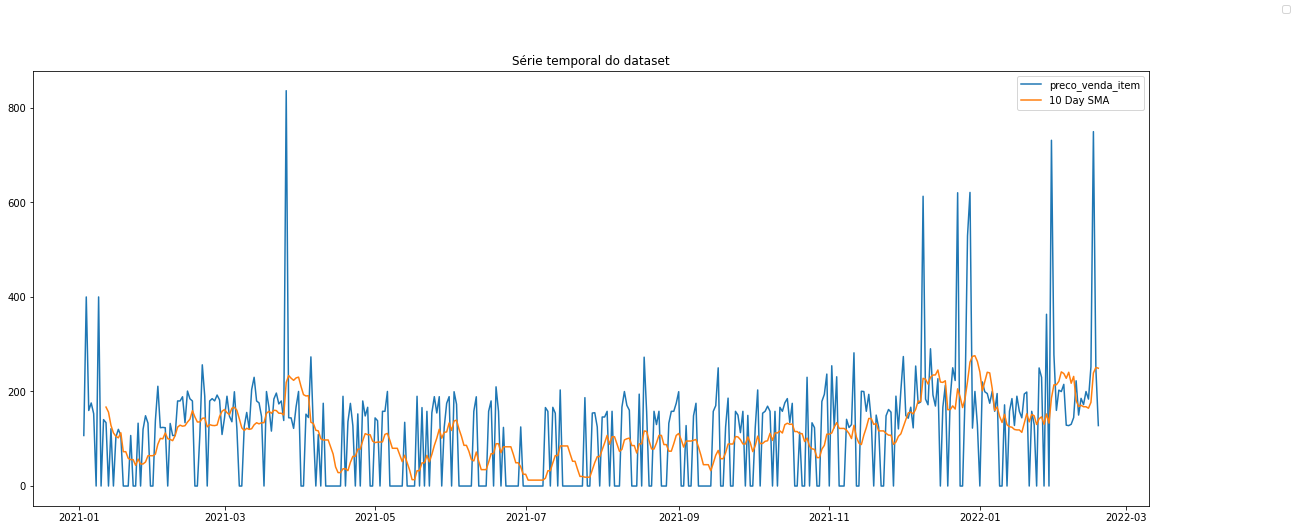

In [ ]:
# Simple Moving Average
group = dfz

sma = get_sma(group, 10)

symbol = 'AAPL'

fig, ax = plt.subplots(figsize=(20,8))

precos = group.values
precos = group.index

# sns.lineplot(x=datas, y=precos)
# sns.lineplot(datas.dropna().unique(),sma, ax=ax)

fig.legend(labels=["Serie Temporal","SMA 10 dias"])
fig.savefig('sma.png')

# plt.title(symbol + ' SMA')
# plt.xlabel('Days')
# plt.ylabel('Closing Prices')
plt.plot(group, label='preco_venda_item')
plt.plot(sma, label='10 Day SMA')
plt.title('Série temporal do dataset')
plt.legend()
# plt.show()

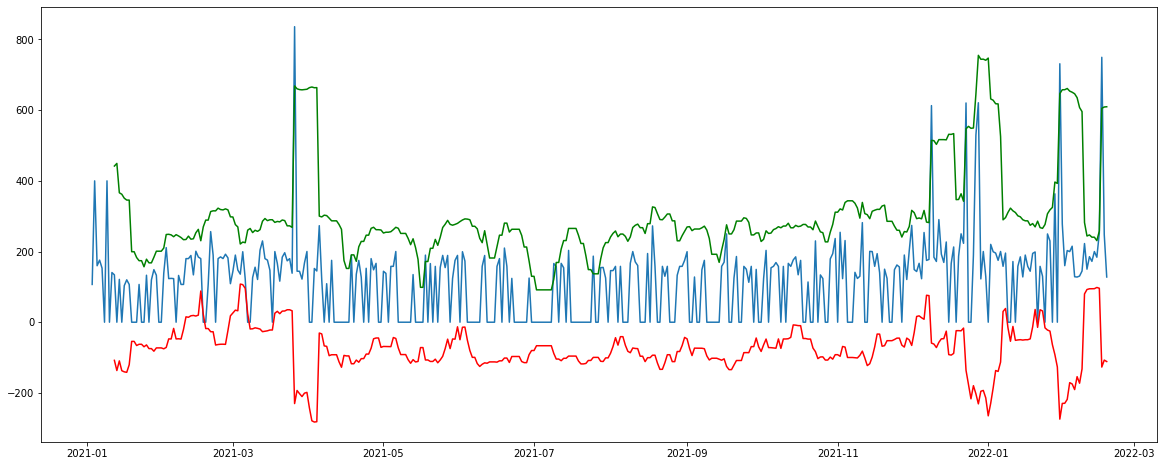

In [ ]:
# rolling standard deviations

bollinger_up, bollinger_down = get_bollinger_bands(group)

fig, ax = plt.subplots(figsize=(20, 8))


# sns.lineplot(x=datas, y=precos)
# sns.lineplot(datas.dropna().unique(),bollinger_up, ax=ax)
# sns.lineplot(datas.dropna().unique(),bollinger_down, ax=ax)

plt.plot(group, label='Closing Prices')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_down, label='Bollinger Down', c='r')

In [ ]:
plotMovingAverage(dfz.order.values, window=10, plot_anomalies=True, plot_intervals=True)

AttributeError: ignored

In [ ]:
# plotMovingAverage(group, window=10, plot_anomalies=True, plot_intervals=True)

<Figure size 720x360 with 0 Axes>

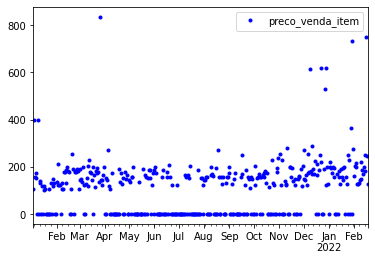

In [ ]:
plt.figure(figsize=(10,5))
group.plot(style='b.')
plt.show()

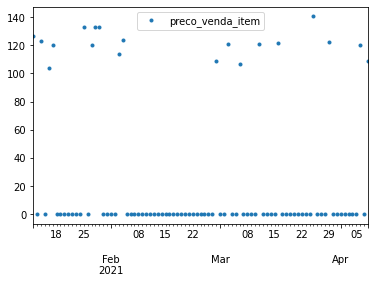

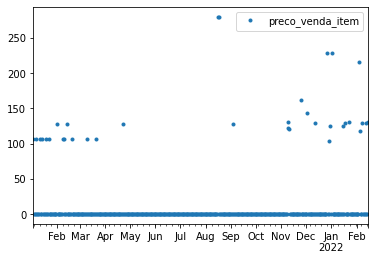

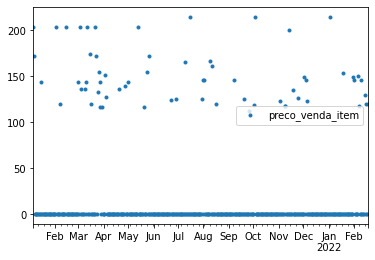

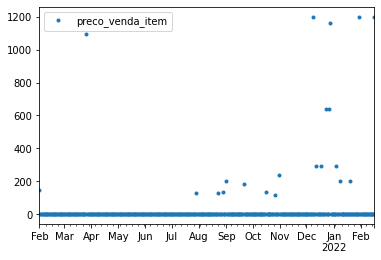

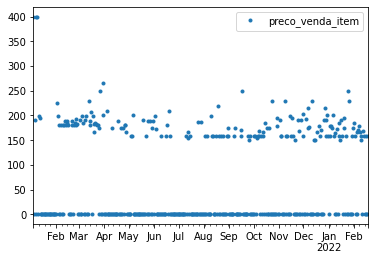

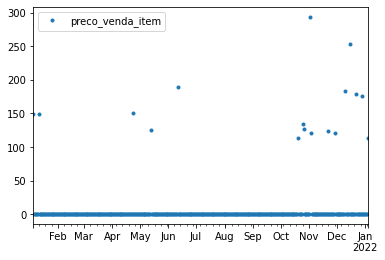

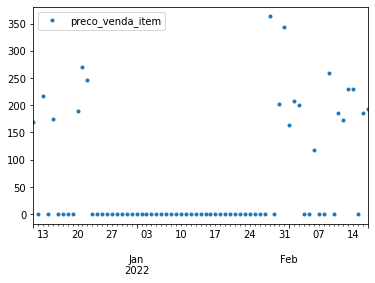

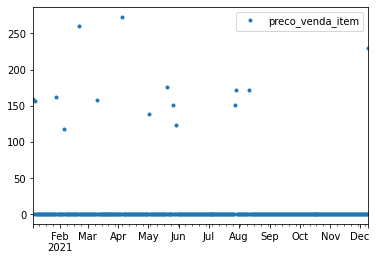

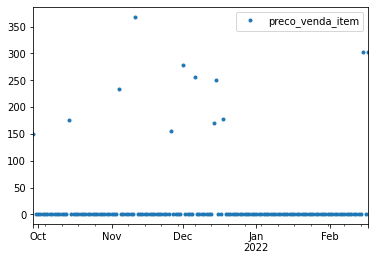

In [ ]:
for vendedor in vendedores:
  # df_ = df[df['id_seller'] == vendedor]
  df_ = dfz_ids[vendedor]
  # group_ = df_.groupby('data_aprovacao_pedido')['preco_venda_item'].mean()
  df_.plot(style='.')

  # group.plot(style='c.')

In [ ]:
series.columns

Index(['preco_venda_item'], dtype='object')

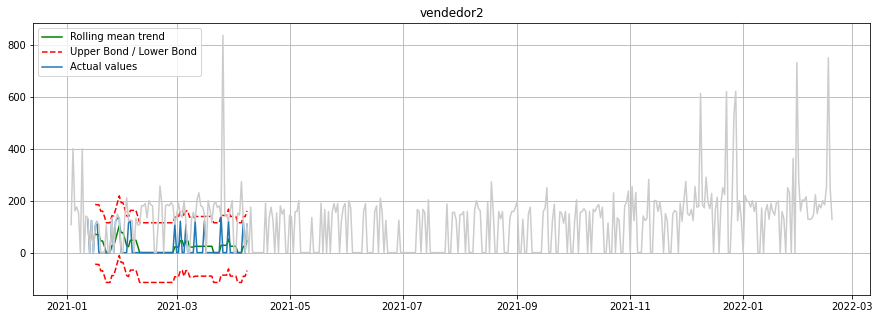

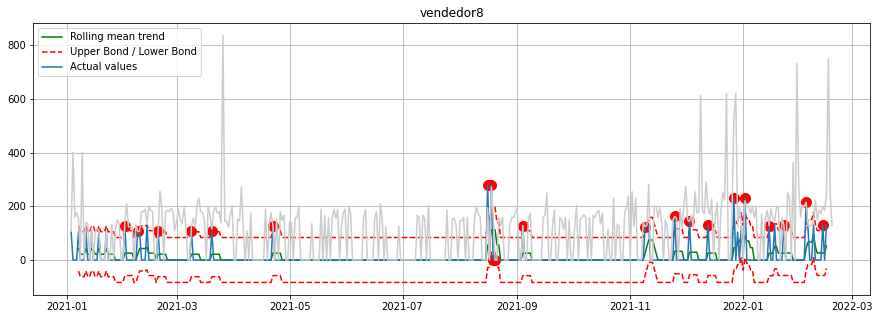

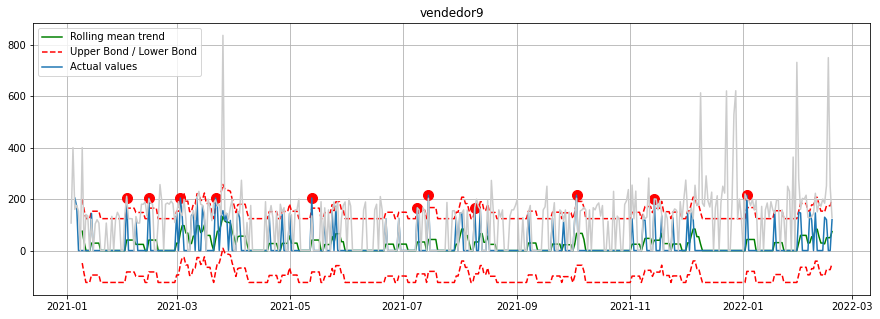

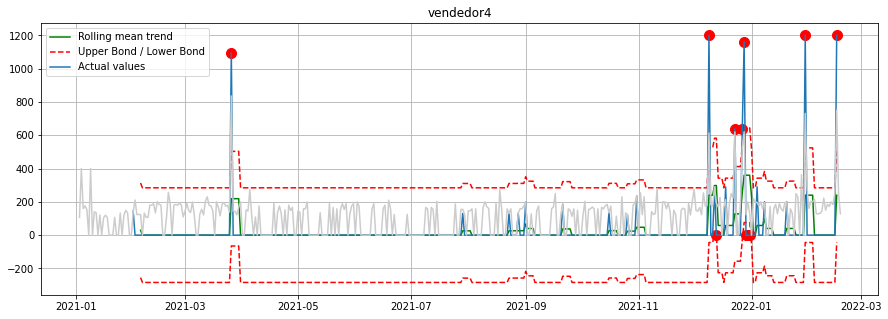

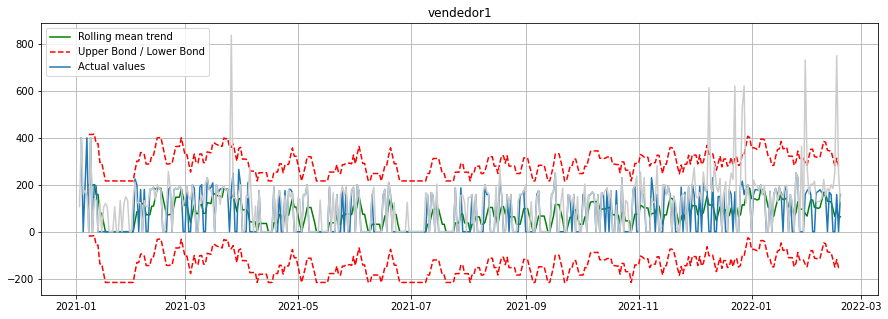

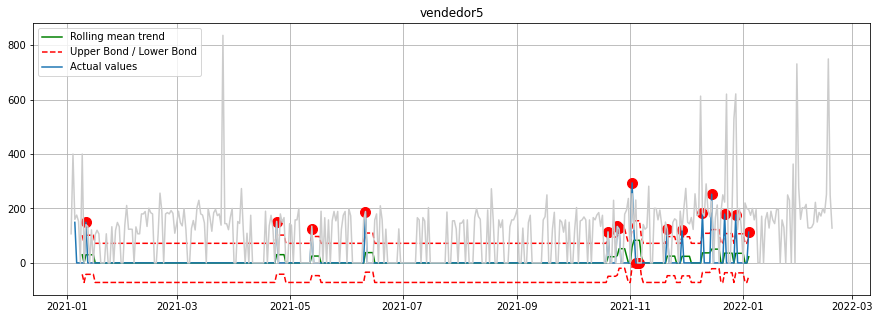

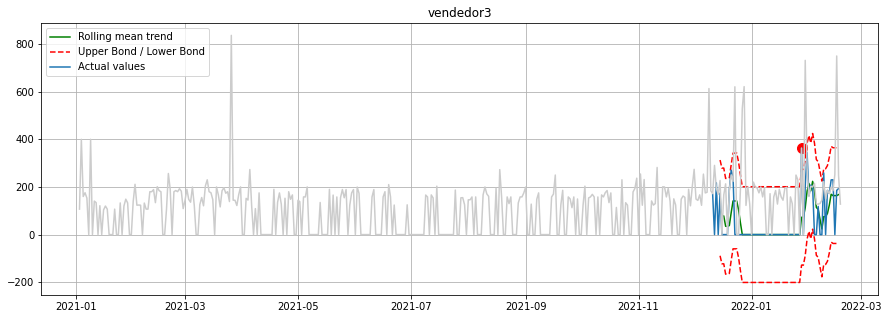

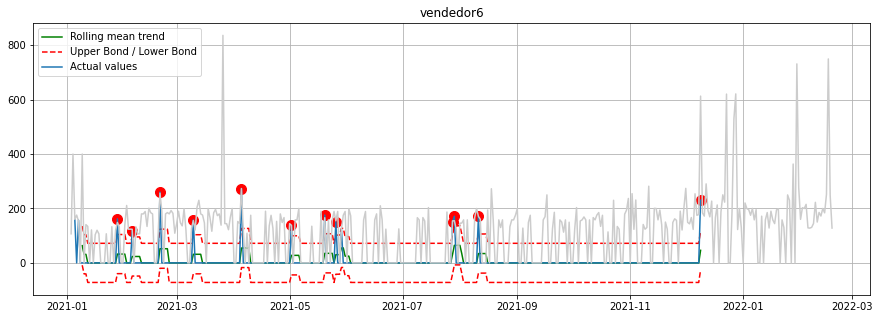

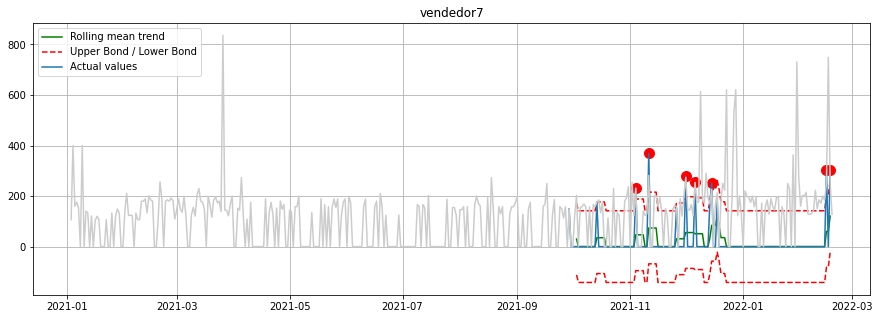

In [ ]:
for vendedor in vendedores:
  # df_ = df[df['id_seller'] == vendedor]
  # group_ = df_.groupby('data_aprovacao_pedido')['preco_venda_item'].mean()
  group_ = dfz_ids[vendedor]

  plotMovingAverage(group_, window=5, plot_anomalies=True, plot_intervals=True)
  plt.plot(group, '0.8' )
  plt.title(vendedor)

A sigla INPC corresponde ao Índice Nacional de Preços ao Consumidor. A sigla IPCA corresponde ao Índice Nacional de Preços ao Consumidor Amplo.

O IPCA engloba uma parcela maior da população. Ele aponta a variação do custo de vida médio de famílias com renda mensal de 1 e 40 salários mínimos.

In [ ]:
ipca = sgs.get({'IPCA' : 433}, start = "2021-01-01", end="2022-02-02")

In [ ]:
data = pd.DataFrame(data)

In [ ]:
df_2021 = df[df.ano_pedido == 2021.0].groupby('mes_pedido')['preco_venda_item'].mean()
df_2022 = df[df.ano_pedido == 2022.0].groupby('mes_pedido')['preco_venda_item'].mean()
data = df_2021.append(df_2022)
data = data.dropna()

In [ ]:
data['ipca'] = ipca.values
data

,preco_venda_item,ipca
mes_pedido,,
1.0,136.794732,0.25
2.0,152.531661,0.86
3.0,199.497380,0.93
4.0,162.229903,0.31
5.0,146.346133,0.83
6.0,169.846769,0.53
7.0,158.616745,0.96
8.0,169.482620,0.87
9.0,160.438202,1.16


In [ ]:
datas

1        2021-01-16
2        2021-01-16
3        2021-01-16
4        2021-01-16
5        2021-01-16
            ...    
131917   2021-02-28
131918   2021-02-28
131919   2021-02-28
131920   2021-02-28
131921   2021-02-28
Name: data_aprovacao_pedido, Length: 131921, dtype: datetime64[ns]

In [ ]:
data.corr()

,preco_venda_item,ipca
preco_venda_item,1.000000,-0.062542
ipca,-0.062542,1.000000


In [ ]:
# create moving-averages

data = pd.DataFrame(dfz)
data['MA10'] = get_sma(group, 10)['MA10']
data['MA5'] = get_sma(group, 5)['MA10']

# data['MA10'] = data['value'].rolling(336).mean()
fig = px.line(data, x=data.index, y=['preco_venda_item', 'MA10', 'MA5'])
fig.show()


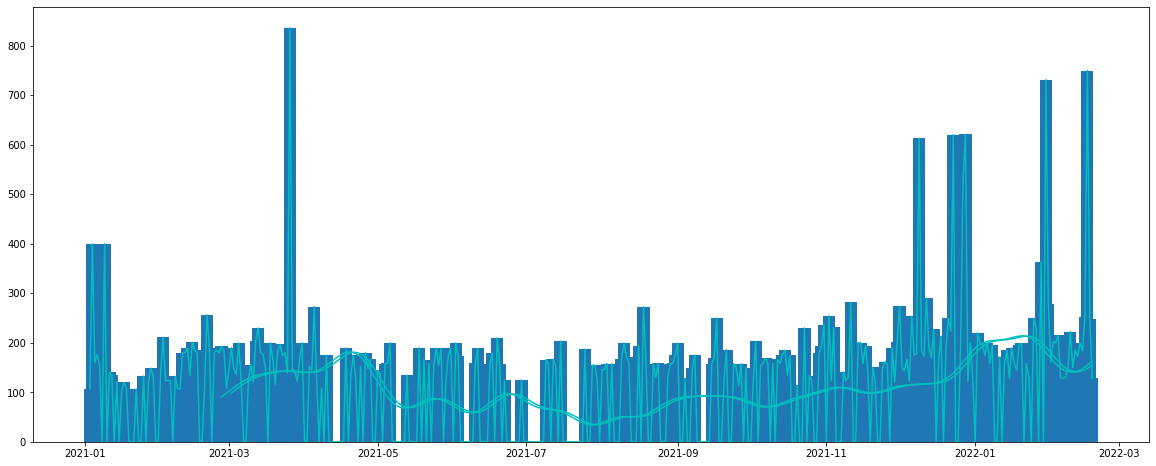

In [ ]:
fig, tsax = plt.subplots(figsize=(20,8))

plt.bar(group.index, group['preco_venda_item'], width=5)
plt.plot(group, 'c')

In [ ]:
plt.plot()

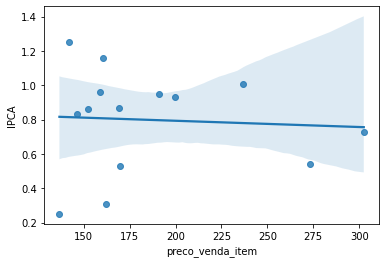

In [ ]:
sns.regplot(x=data, y=ipca)

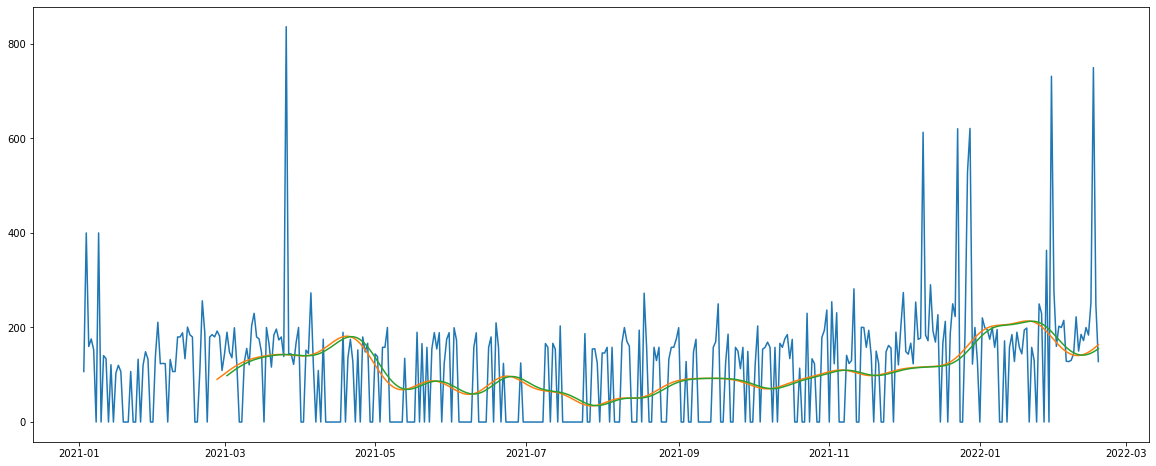

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(group)
# plt.plot(ipca)


In [ ]:
group

data_aprovacao_pedido
2021-01-03    106.865691
2021-01-04    399.881389
2021-01-05    159.785068
2021-01-06    175.680798
2021-01-07    152.991004
                 ...    
2022-02-14    183.910508
2022-02-15    252.148529
2022-02-16    749.507325
2022-02-17    247.892808
2022-02-18    127.893583
Name: preco_venda_item, Length: 258, dtype: float64

In [ ]:
corr(ipca, precos)

NameError: ignored

(array([737791., 737850., 737911., 737972., 738034., 738095., 738156.]),
 <a list of 7 Text major ticklabel objects>)

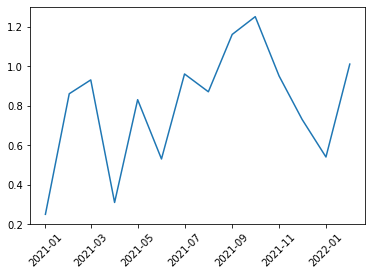

In [ ]:
plt.plot(ipca)
plt.xticks(rotation=45)

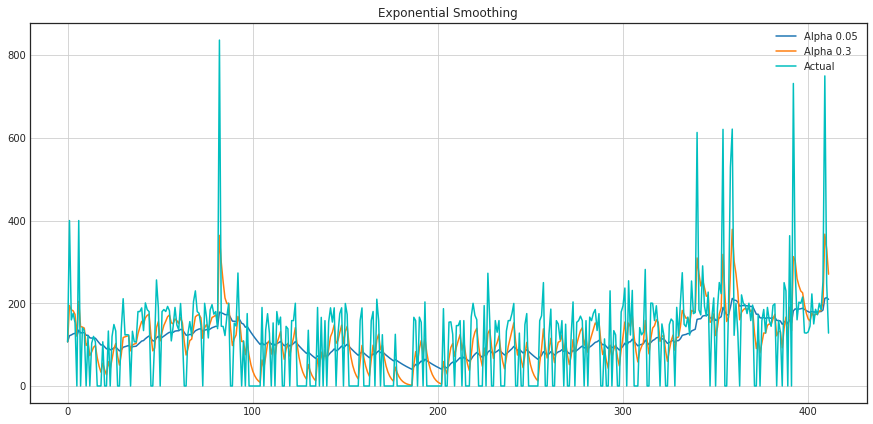

In [ ]:
plotExponentialSmoothing(group['preco_venda_item'], [0.05,0.3])

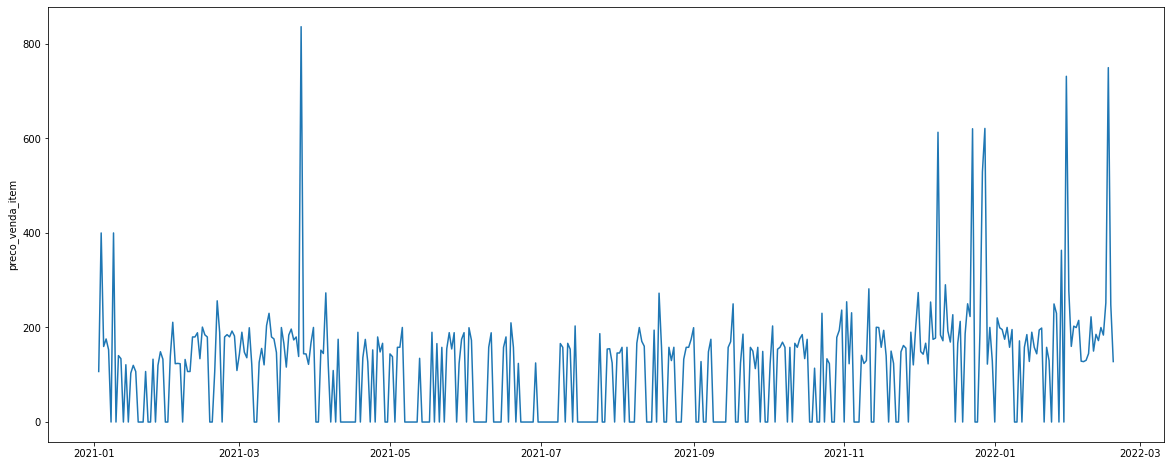

In [ ]:
fig = plt.figure(figsize = (20,8))
sns.lineplot(x = dfz.index, y = 'preco_venda_item' ,data = dfz)
# sns.lineplot(x=dfz.values, y=dfz.index, data=dfz)
fig.savefig('data_aprov_por_precoitem.png', dpi=fig.dpi)


In [ ]:
vendedores = df['id_seller'].unique()

dic_ = {}

for vendedor in vendedores:
  x = df[df['id_seller'] == vendedor]['data_aprovacao_pedido']
  dic_[vendedor]= [x.min().date(), x.max().date()]
dic_

hi = pd.DataFrame(dic_)
hi['index'] =['min', 'max']
hi.set_index('index')

,vendedor2,vendedor8,vendedor9,vendedor4,vendedor1,vendedor5,vendedor3,vendedor6,vendedor7
index,,,,,,,,,
min,2021-01-12,2021-01-03,2021-01-05,2021-02-01,2021-01-04,2021-01-05,2021-12-11,2021-01-05,2021-09-29
max,2021-04-08,2022-02-15,2022-02-18,2022-02-16,2022-02-18,2022-01-04,2022-02-17,2021-12-09,2022-02-17


## Análise exploratória dados multivariados

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

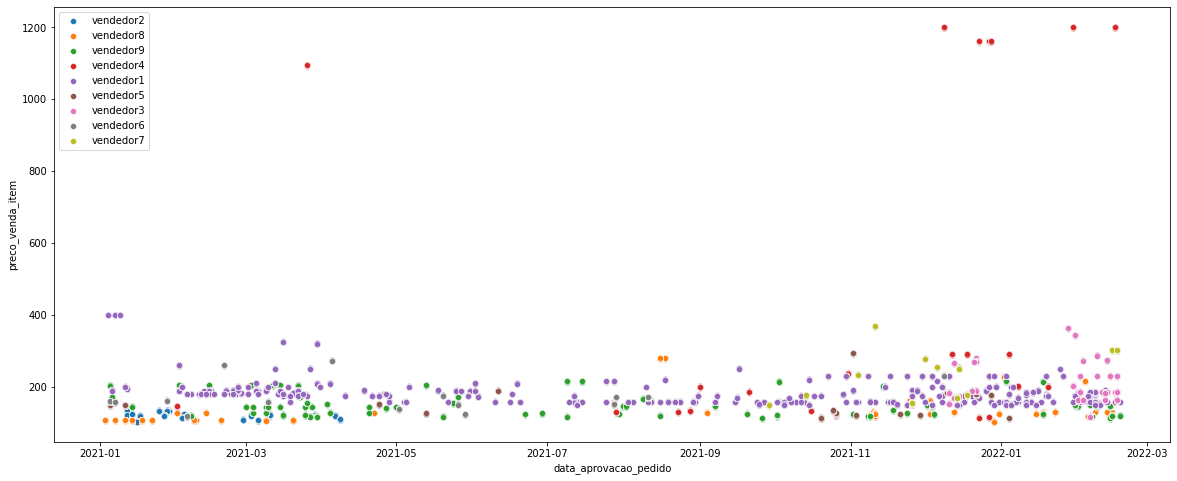

In [ ]:
vendedores = df['id_seller'].unique()

f = plt.figure(figsize = (20,8))

for vendedor in vendedores:
  f.add_subplot()
  sns.scatterplot(x = 'data_aprovacao_pedido', y = 'preco_venda_item',
               data= df[df['id_seller'] == vendedor])
plt.legend(vendedores)

In [ ]:
# #Série temporal do preço médio dos produtos dos vendedores, sem o vendedor 4
# vendedores = ['vendedor1','vendedor2','vendedor3','vendedor5','vendedor6','vendedor7','vendedor8','vendedor9']

# fig = plt.figure(figsize=(20,8))

# for vendedor in vendedores:
#   plot_ = df[df['id_seller']==vendedor][['id_seller', 'data_aprovacao_pedido', 'preco_venda_item']]
#   plot_["data_aprovacao_pedido"] = pd.to_datetime(plot_["data_aprovacao_pedido"]) 
#   x = plot_.groupby('data_aprovacao_pedido')["preco_venda_item"].mean().index
#   y = plot_.groupby('data_aprovacao_pedido')["preco_venda_item"].mean()  
#   plt.plot(x,y)

# plt.xlabel('Data de aprovação do pedido')
# plt.ylabel('Valor médio dos produtos vendidos')
# plt.title('Valor médio dos produtos vendido por cada vendedor')

# plt.legend(vendedores)

# fig.savefig('dataaprov_valormedio_vendedor.png', dpi=fig.dpi)


# plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

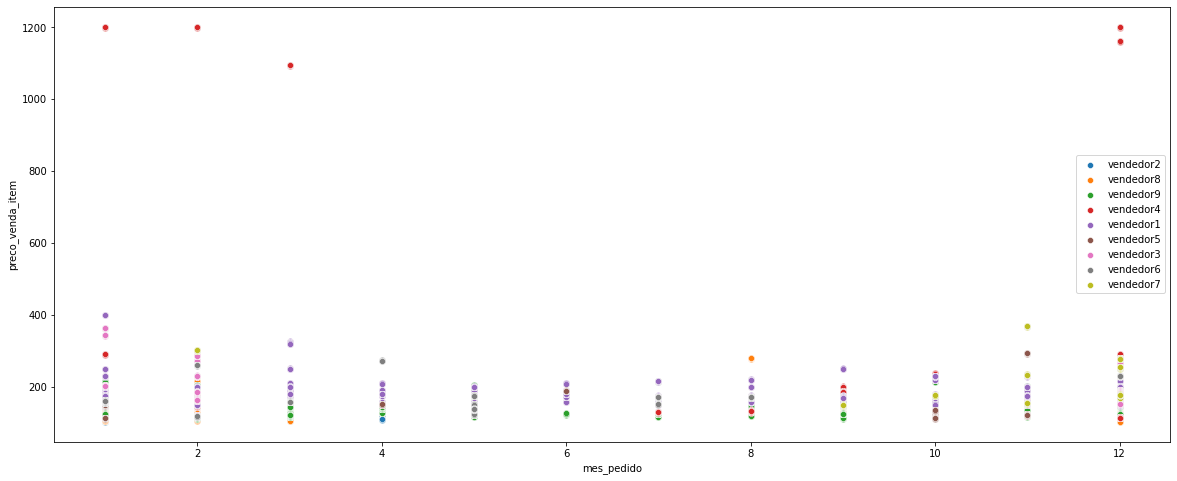

In [ ]:
vendedores = df['id_seller'].unique()

f = plt.figure(figsize = (20,8))

for vendedor in vendedores:
  f.add_subplot()
  sns.scatterplot(x = 'mes_pedido', y = 'preco_venda_item',
               data= df[df['id_seller'] == vendedor])
plt.legend(vendedores)

f.savefig('mespedido_preco_vendedor.png', dpi=f.dpi)


In [ ]:
# TODO: preco de vendas mensais por vendedor em um plot 4*4 

# Modelo ARIMA

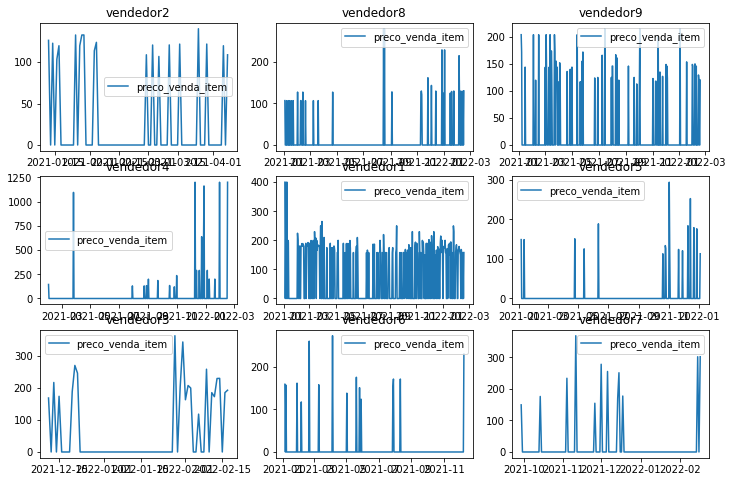

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(12,8))

vendedores = df.id_seller.unique()

for i, vendedor in enumerate(vendedores):
  sns.lineplot(data=df_zeros(df, id_seller=vendedor),
               ax= ax[axs[i]]).set_title(vendedor)
            

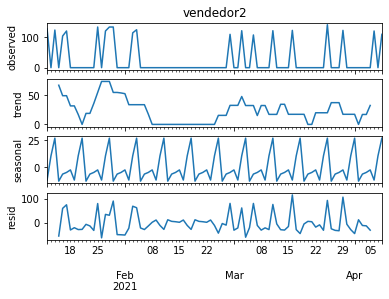

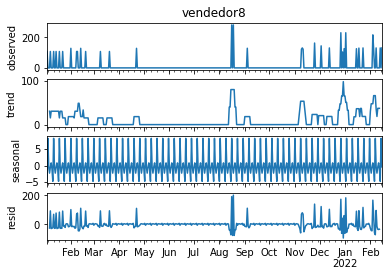

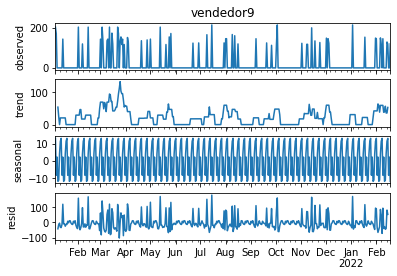

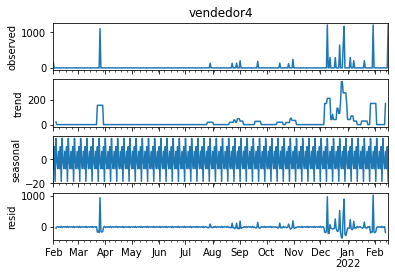

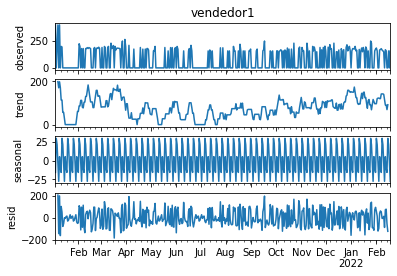

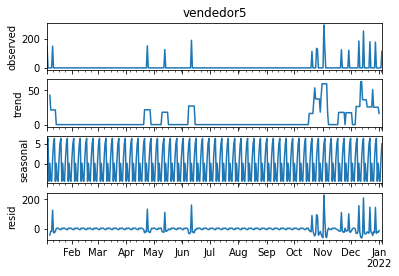

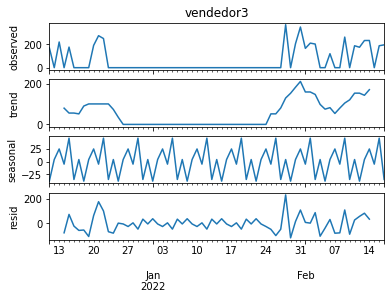

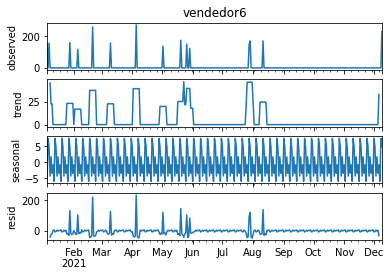

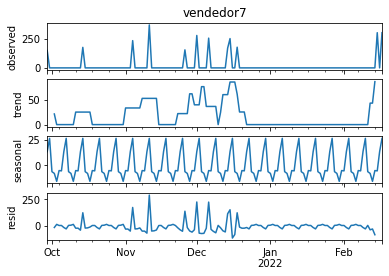

In [ ]:
attr = ['observed', 'trend', 'seasonal', 'resid']

for vendedor in vendedores:
    fig, ax = plt.subplots(len(attr), 1, sharex=True)
    # df_seller = df_zeros(df, id_seller=vendedor)
    df_seller = dfz_ids[vendedor]
    sd = seasonal_decompose(df_seller, model = "additive")

    for idx, a in enumerate(attr):
        s_attr = getattr(sd, a)
        s_attr.plot(ax = ax[idx], title = vendedor if idx == 0 else None)
        ax[idx].set(ylabel= a)

In [ ]:
# TODO: ver resíduos (tem q similar a regressão)
  # - se tiver autocorrelação, ajustar arima nos resíduos
# TODO: métricas: rmse, mae, mape

In [ ]:
attr

['observed', 'trend', 'seasonal', 'resid']

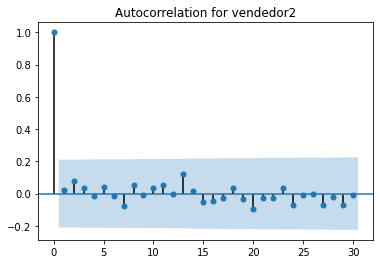

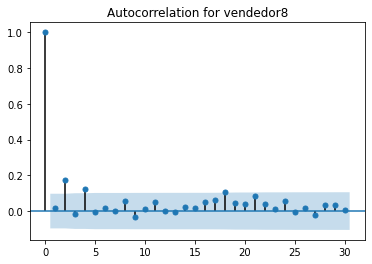

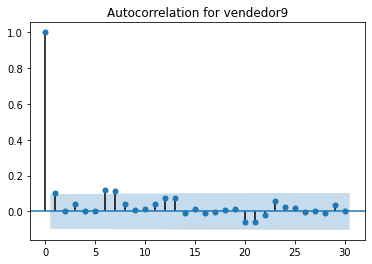

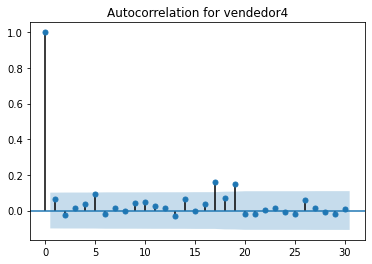

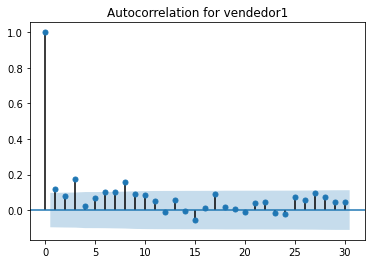

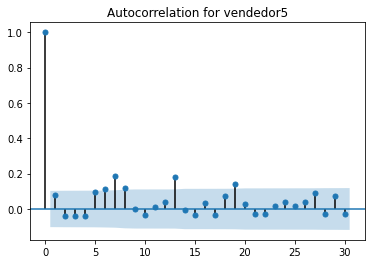

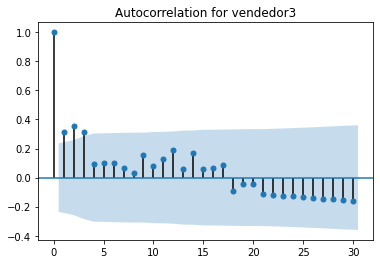

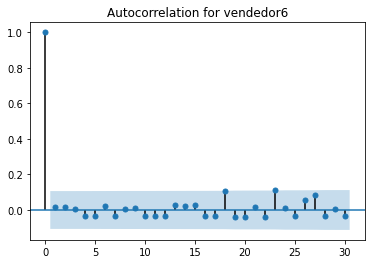

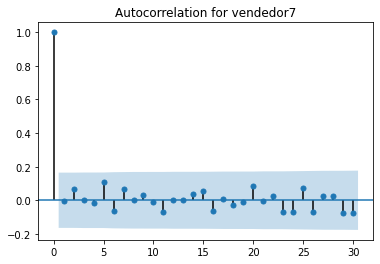

In [ ]:
# Correlograma

for vendedor in vendedores:
    df_seller = dfz_ids[vendedor]
    plot_acf(df_seller, lags=30, title=f'Autocorrelation for {vendedor}')

# plot_pacf(test, lags=30)
# plt.show()

In [ ]:
dfz_ids = dfz_per_id(df)

In [ ]:
for vendedor in vendedores:
    df_seller = dfz_ids[vendedor]
    result = test_stationarity(df_seller, 
                               column='preco_venda_item', 
                               series=True)
    print(f'Teste de estacionariedade para o {vendedor}: {result}')

Teste de estacionariedade para o vendedor2: Stationary
Teste de estacionariedade para o vendedor8: Stationary
Teste de estacionariedade para o vendedor9: Stationary
Teste de estacionariedade para o vendedor4: Stationary
Teste de estacionariedade para o vendedor1: Stationary
Teste de estacionariedade para o vendedor5: Stationary
Teste de estacionariedade para o vendedor3: Non-Stationary
Teste de estacionariedade para o vendedor6: Stationary
Teste de estacionariedade para o vendedor7: Stationary


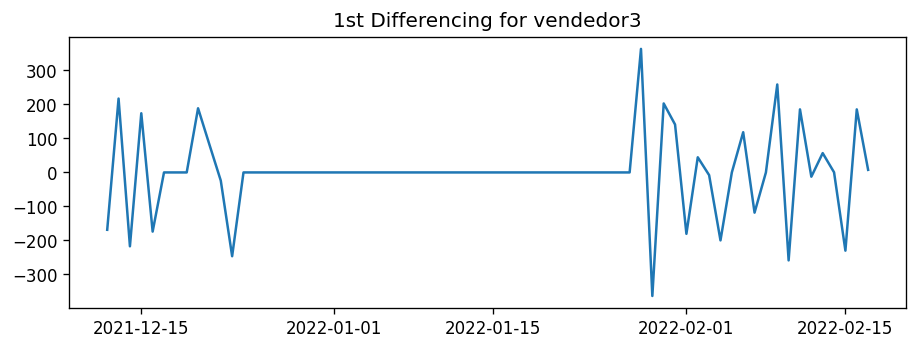

In [ ]:
# q term for the MA

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

df_seller3 = dfz_ids['vendedor3']
plt.plot(df_seller3.diff(1)); 
plt.title('1st Differencing for vendedor3')
# plot_acf(test.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
df_seller3 = df_seller3.diff(1)
result = test_stationarity(df_seller3.dropna(), 
                               column='preco_venda_item', 
                               series=True)
print(f'Teste de estacionariedade para o vendedor3: {result}')

Teste de estacionariedade para o vendedor3: Stationary


In [ ]:
dfz_ids['vendedor3'] = df_seller3

In [ ]:
new_dfz = dfz.copy()
arima=ARIMA(new_dfz['preco_venda_item'].values)
arima_fit = arima.fit()
squared_errors = arima_fit.resid **2
predictions, threshold = find_anomalies(squared_errors)
new_dfz['predictions'] = [new_dfz['preco_venda_item'].iloc[i] if pred > 0 else 0 for i, pred in enumerate(predictions)]

In [ ]:
preco = new_dfz['preco_venda_item']
pred = pd.DataFrame([i if i > 0 else np.nan for i in new_dfz['predictions']]).set_index(new_dfz[:60].index)

plt.plot(preco)
plt.plot(pred, 'ro')
# plt.set_title(vendedor)

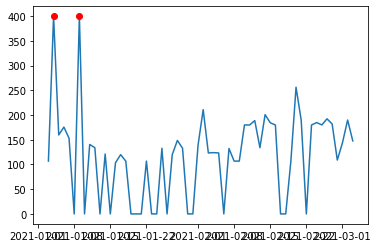

In [ ]:
preco = new_dfz['preco_venda_item'][:60]
pred = pd.DataFrame([i if i > 0 else np.nan for i in new_dfz['predictions'][:60]]).set_index(new_dfz[:60].index)

plt.plot(preco)
plt.plot(pred, 'ro')
# plt.set_title(vendedor)

In [ ]:
for vendedor in vendedores:
    df_seller = dfz_ids[vendedor]
    arima = ARIMA(df_seller['preco_venda_item'].values)
    arima_fit = arima.fit()
    squared_errors = arima_fit.resid **2
    predictions, threshold = find_anomalies(squared_errors)
    dfz_ids[vendedor]['predictions'] = [df_seller['preco_venda_item'].iloc[i] if pred > 0 else 0 for i, pred in enumerate(predictions)]

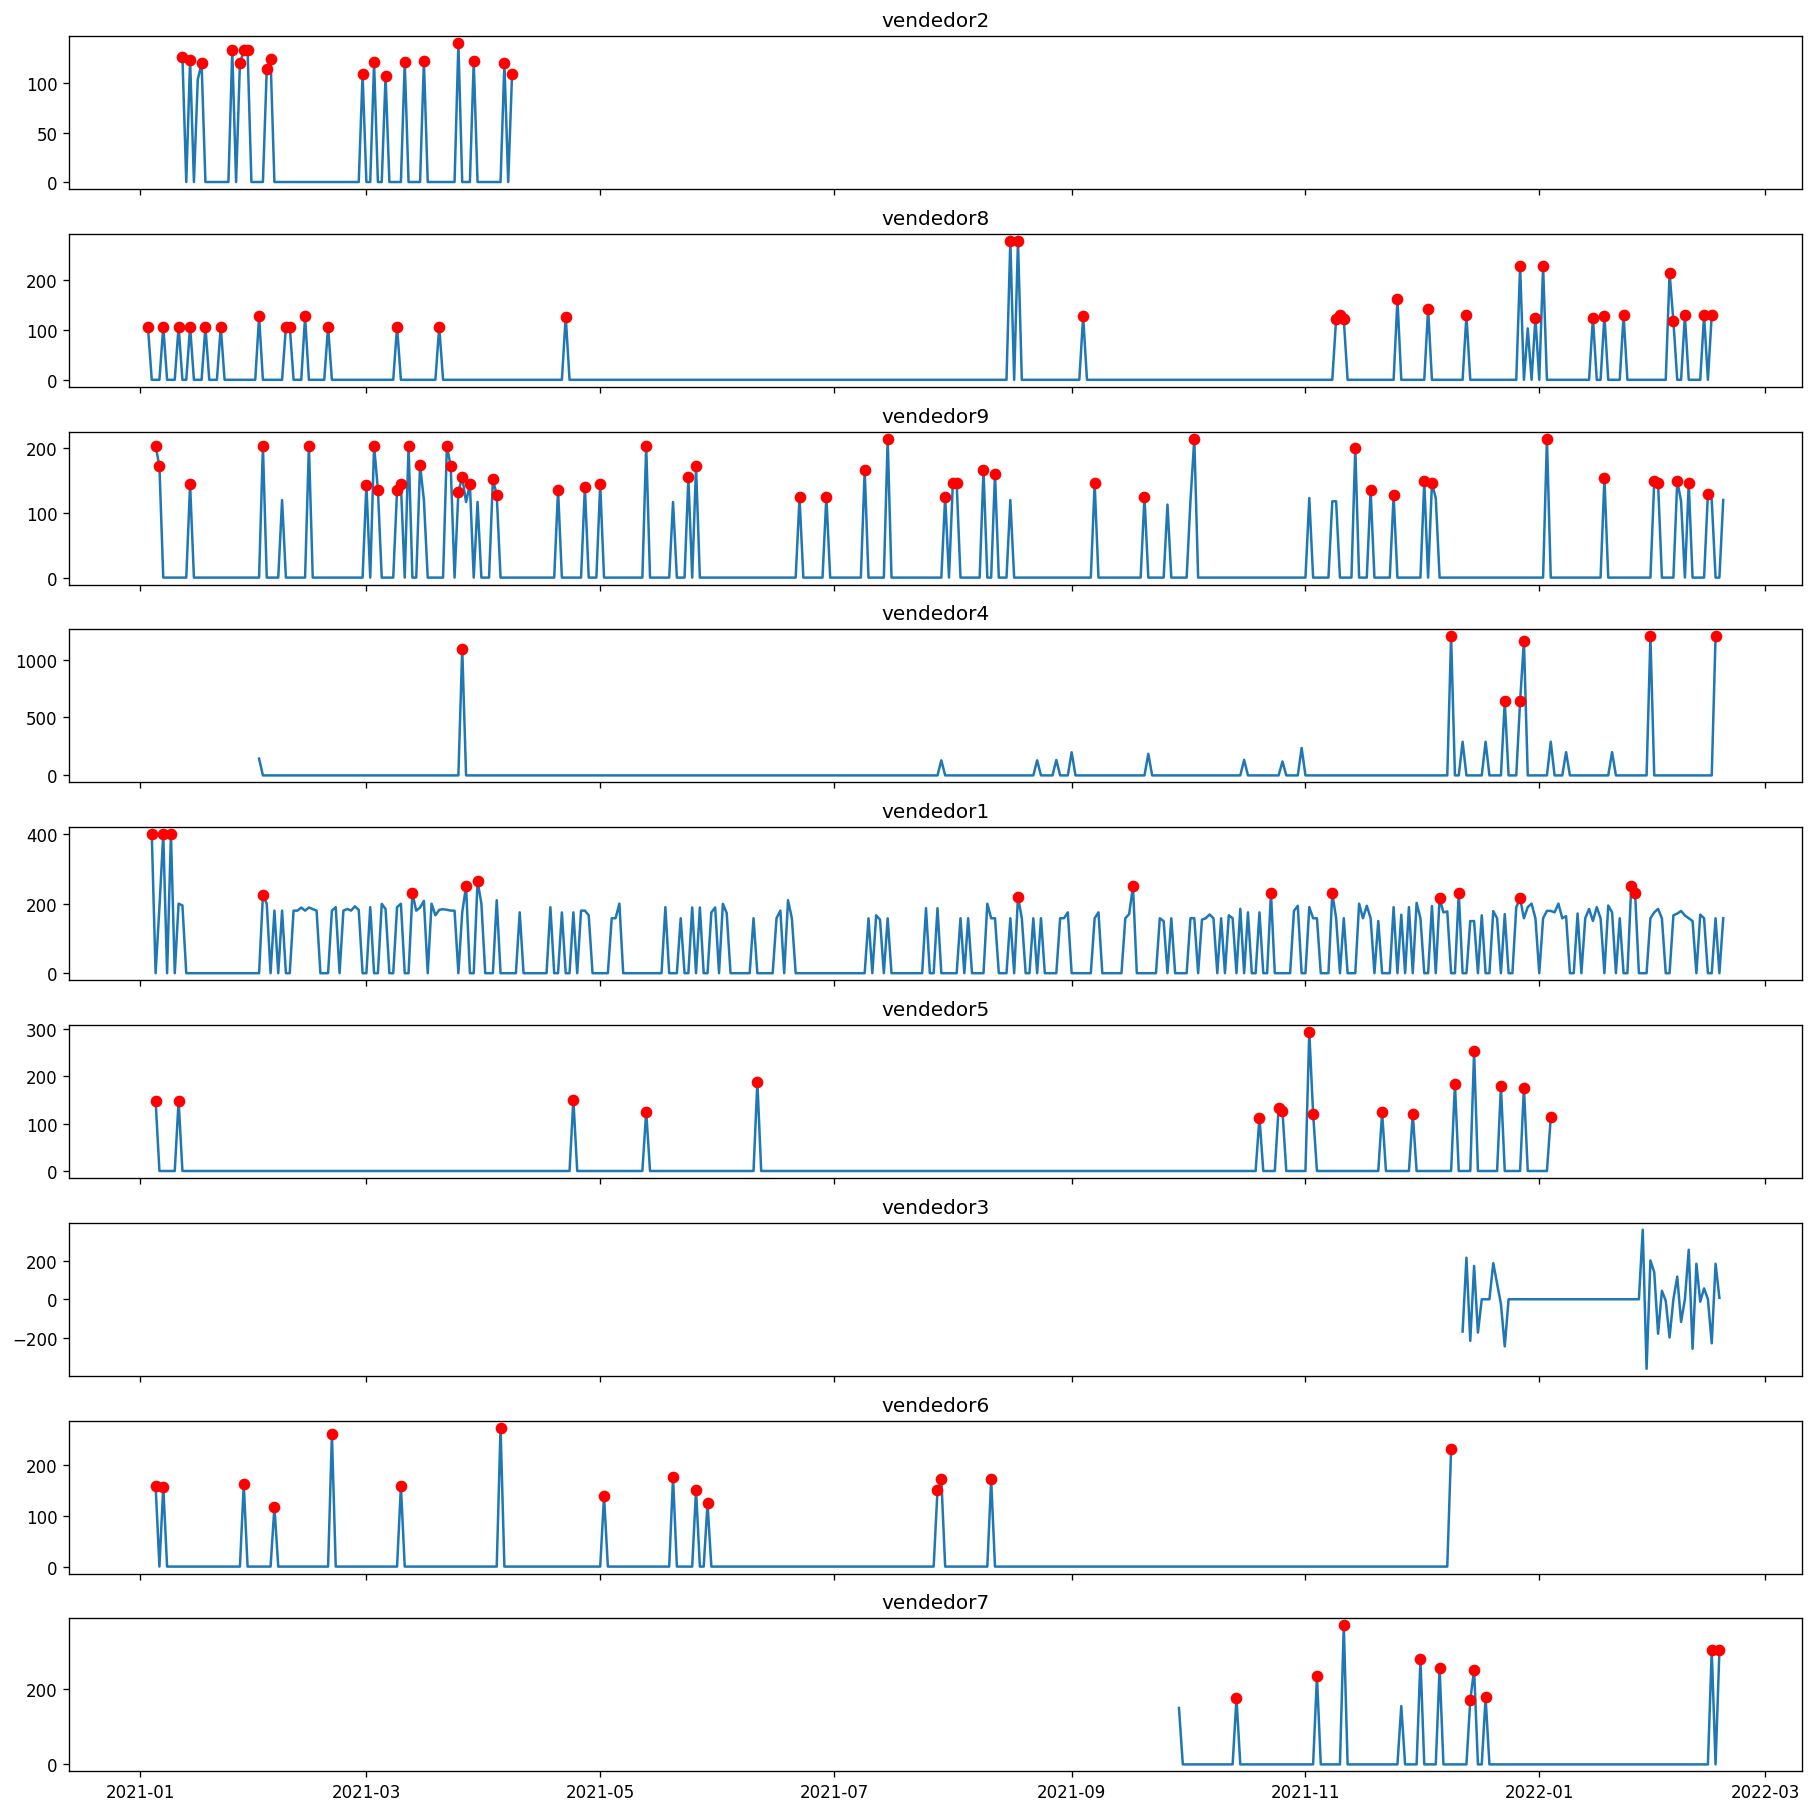

In [ ]:
fig, ax = plt.subplots(len(vendedores), 1,
                       figsize=(15,15),
                       constrained_layout = True,
                       sharex=True,
                      #  sharey=True
                       )

for i, vendedor in enumerate(vendedores):
    df_seller = dfz_ids[vendedor]
    preco = df_seller['preco_venda_item']
    pred = pd.DataFrame([i if i > 0 else np.nan for i in df_seller['predictions']]).set_index(df_seller.index)

    ax[i].plot(preco)
    ax[i].plot(pred, 'ro')
    ax[i].set_title(vendedor)

In [ ]:
# my_arima = oa.Arima_anomaly_detection()

# for vendedor in vendedores:
#     # if vendedor == 'vendedor3':
#     #     df_seller = df_zeros(df, vendedor, diff_=1)
#     # else:
#     #     df_seller = df_zeros
#     df_seller = dfz_ids[vendedor]['preco_venda_item']
    
#     my_arima.fit(df_seller)
#     # ts_anomaly = my_arima.predict(df_seller)

In [ ]:
# test2 = np.array(test.preco_venda_item)
# argrelextrema(test2, np.greater)

## SARIMA


In [ ]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=321cc1fd0996d0bd13f77c1b282dceee4eba7bead1b2b3f5983256685a861f25
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
import pandas as pd
import numpy as np
import time
import sys
from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
# import plotly.plotly as py
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

In [ ]:
dfz['date'] = dfz.index
dfz.rename(
    columns= {
        'preco_venda_item': 'order'
    }, 
    inplace=True
)
order_df = dfz

In [ ]:
# order_df = df[['preco_venda_item', 'data_aprovacao_pedido']]
# order_df.rename(
#     columns= {
#         'preco_venda_item': 'order'
#     }, 
#     inplace=True
# )

In [ ]:
data = [
    go.Scatter(
        x=order_df.index, # assign x as the dataframe column 'x'
        y=order_df.order
    )
]

iplot(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



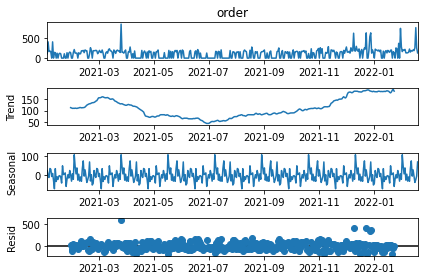

In [ ]:
res = sm.tsa.seasonal_decompose(order_df['order'].interpolate(),
                                freq=52,
                                model='additive')
resplot = res.plot()

In [ ]:
res.resid[np.isfinite(res.resid) == False] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



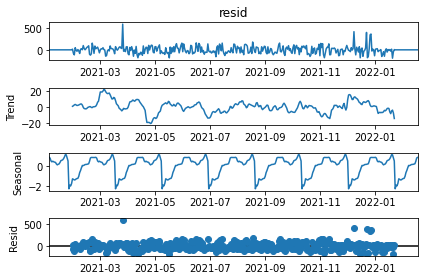

In [ ]:
res_resid = sm.tsa.seasonal_decompose(res.resid.interpolate(),
                                freq=52,
                                model='additive ')
resplot = res_resid.plot()

In [ ]:
mid = int(np.round(len(order_df)*0.8))
train = order_df.head(mid)
train_se = pd.Series(data = train['order'], index = train['date'] )
train_se = train_se.asfreq('W-Mon')

test = order_df[mid:]
test_se = pd.Series(data = test['order'], index = test['date'] )
test_se = test_se.asfreq('W-Mon')

print (train_se.tail(), test_se.head())

date
2021-10-25    133.787713
2021-11-01      0.000000
2021-11-08    141.100094
2021-11-15    199.846099
2021-11-22      0.000000
Freq: W-MON, Name: order, dtype: float64 date
2021-11-29    120.807947
2021-12-06    253.794956
2021-12-13    192.602286
2021-12-20    186.747182
2021-12-27    529.043094
Freq: W-MON, Name: order, dtype: float64


In [ ]:
import itertools  

# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

seasonal = 52
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

In [ ]:
# compute the Akaike Information Criterion (AIC): choose the model with lowest AIC.
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(train_se,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)
            
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        
        except:
            print(param,param_seasonal, "Unexpected error:", sys.exc_info()[1])
            continue
            
            
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Best SARIMAX(0, 0, 0)x(0, 1, 0, 52)12 model - AIC:2.0


In [ ]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(train_se,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
res = mdl.fit()

# print statistics
print(res.aic)
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



8.0
                                      SARIMAX Results                                      
Dep. Variable:                               order   No. Observations:                   47
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood                   0.000
Date:                             Mon, 18 Jul 2022   AIC                              8.000
Time:                                     20:31:08   BIC                                nan
Sample:                                 01-04-2021   HQIC                               nan
                                      - 11-22-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3053: UserWarning:

Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1107: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1216: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/eval_measures.py:370: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/eval_measures.py:394: RuntimeWarning

In [ ]:
from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=192-3)
chi

222.07564642657547

In [ ]:
# res.plot_diagnostics(figsize=(16, 10))
# plt.tight_layout()
# plt.show()

In [ ]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

In [ ]:
pred2 = res.get_prediction(start=mid, end=mid+len(test_se)-1)
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               order   No. Observations:                   47
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood                   0.000
Date:                             Mon, 18 Jul 2022   AIC                              8.000
Time:                                     20:31:09   BIC                                nan
Sample:                                 01-04-2021   HQIC                               nan
                                      - 11-22-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3053: UserWarning:

Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1107: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1216: RuntimeWarning:

Mean of empty slice.



In [ ]:
pred2.predicted_mean 

2027-05-03   -1199.643566
2027-05-10   -1199.643566
2027-05-17   -1044.649058
2027-05-24   -1010.634192
2027-05-31   -1199.643566
2027-06-07   -1199.643566
2027-06-14   -1199.643566
2027-06-21   -1199.643566
2027-06-28   -1199.643566
2027-07-05   -1033.184278
2027-07-12   -1199.643566
2027-07-19   -1199.643566
Freq: W-MON, dtype: float64

ValueError: ignored

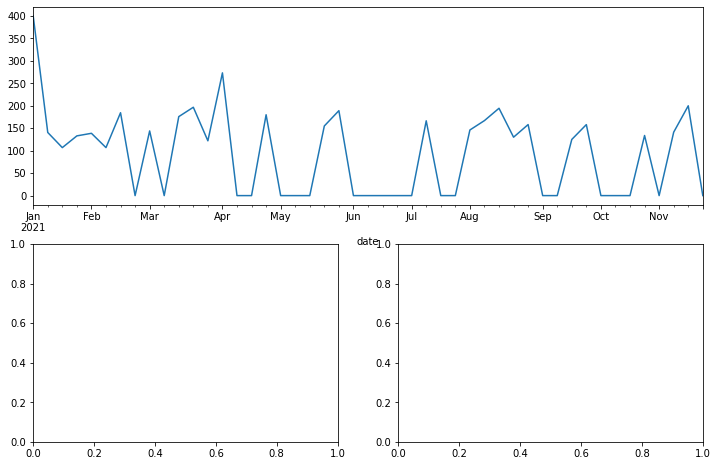

In [ ]:
def plotSARIMAX_m(train_data, test_data, pred_model):
    fig = plt.figure(figsize=(12, 8))
    layout = (2, 2)
    ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax3 = plt.subplot2grid(layout, (1, 0))
    ax4 = plt.subplot2grid(layout, (1, 1))
    train_data.plot(ax=ax1);
    t = 'MSE: {}'.format(mean_squared_log_error(test_data,pred_model.predicted_mean))
    pred_model.predicted_mean.plot(ax=ax1, title=t, label = 'Prediction')
    test_data.plot(ax=ax1, label = 'Reality')
    ax1.fill_between(pred_model.conf_int(alpha = 0.1).index, 
                     pred_model.conf_int(alpha = 0.1).iloc[:,0], 
                     pred_model.conf_int(alpha = 0.1).iloc[:,1], 
                     alpha=0.5,facecolor='grey')
    ax3 = sm.graphics.tsa.plot_acf(res.resid, lags=seasonal, alpha=.05, ax=ax3, title="ACF of residuals")
    ax4 = sm.graphics.tsa.plot_pacf(res.resid, lags=seasonal, alpha=.05, ax=ax4, title="PACF of residuals")
    plt.tight_layout()
    ax1.legend()
    print("ACF and PACF of residuals")

plotSARIMAX_m(train_se, test_se, pred2)

In [ ]:
def accuracy(test_data, model, alpha=0.05):
    a = 0
    anomly = list()
    for i in range(len(test_data)):
        if (test_data[i] >=  model.conf_int(alpha = alpha).iloc[i,0] 
            and test_data[i] <=  model.conf_int(alpha = alpha).iloc[i,1]): 
            a += 1
        else: anomly.append([str(test_data.index[i]), test_data[i]])
  
    return round(a/len(test_data),4), anomly
    
def compare_acc(test_data, model, range_start, range_end, range_sep):
    alpha = np.arange(range_start,range_end, range_sep)
    acc = pd.DataFrame(columns = ['alpha','acc','no_of_ab'], dtype=object)
    acc["alpha"] = alpha
    for i in range(len(alpha)):
        acc.iloc[i,1] = accuracy(test_data, model, alpha=alpha[i])[0]
        acc.iloc[i,2] = len(accuracy(test_data, model, alpha=alpha[i])[1])
        
    data = [
        go.Scatter(
            x=acc.alpha, # assign x as the dataframe column 'x'
            y=acc.acc,
            name ='Accuracy'
        ),
        go.Scatter(
            x=acc.alpha,
            y=acc.no_of_ab,
            name = 'The number of abnomal date',
            yaxis='y2'
        )
    ]
    
    layout = go.Layout(
    title='Accuracy comparison based on different Alpha',
    yaxis=dict(
        title='Accuracy'
    ),
    yaxis2=dict(
        title='Abnormal Date',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
    fig = go.Figure(data=data, layout=layout)
    return iplot(fig)

compare_acc(test_se, pred2,0.01,0.2,0.01)

In [ ]:
def hightlight(alpha, test_data = test_se, model = pred2):
    anomly_date = accuracy(test_data, model, alpha=alpha)[1]
    anomly = pd.DataFrame(columns = ['alpha','anomly_date','anomly_y'], dtype=object)
    anomly['org'] = anomly_date[:]
    for i in range(len(anomly_date)):
        anomly.iloc[i,0] = alpha
        anomly.iloc[i,1] = anomly.iloc[i,3][0]
        anomly.iloc[i,2] = anomly.iloc[i,3][1]
    return anomly

import random
def random_color():
    r = random.randint(50,255)
    g = random.randint(50,255)
    b = random.randint(50,255)
    return (r,g,b)

def areaplot(alpha):
    color = random_color()
    trace0 = go.Scatter(
        x=pred2.conf_int(alpha=alpha).index,
        y=pred2.conf_int(alpha=alpha).iloc[:,1],
        fill= None,
        mode='lines',
        showlegend=False,
        name='Upper Bound',
        line=dict(width=0.5,
                  color='rgba({},{},{},{})'.format(color[0],color[1],color[2],0.5)
        ))
    trace1 = go.Scatter(
        x=pred2.conf_int(alpha=alpha).index,
        y= pred2.conf_int(alpha=alpha).iloc[:,0],
        fill='tonexty',
        mode='lines',
        line=dict(width=0.5,
                  color='rgba({},{},{},{})'.format(color[0],color[1],color[2],0.5)),
        name = 'alpha = {}'.format(alpha)
        )
    trace2 = go.Scatter(
        x=test_se.index, # assign x as the dataframe column 'x'
        y=test_se,
        name = 'Real data',
        line=dict(color='rgb{}'.format(color)),
        mode='lines')

    trace3 = go.Scatter(
        x = hightlight(alpha).anomly_date,
        y = hightlight(alpha).anomly_y,
        name = 'Alert points',
        hoverinfo='none',
        mode = 'markers'
    )
    data = [trace0, trace1, trace2, trace3]
    return iplot(data)
##rgb(255,253,180),'rgb(255,216,55)'

In [ ]:
areaplot(0.01)

# DeepAnT

# Deepant

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import SGD
import os

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [ ]:
# Anomaly detector
def anomaly_detector(prediction_seq, ground_truth_seq):
    # calculate Euclidean between actual seq and predicted seq
    dist = np.linalg.norm(ground_truth_seq - prediction_seq)  
    return dist > anm_det_thr

In [ ]:
"""Hyperparameters"""
w = 60                 # History window (number of time stamps taken into account) <<<<<<<<<<<<<<<<
                         # i.e., filter(kernel) size       
p_w = 10                # Prediction window (number of time stampes required to be  <<<<<<<<<<<<<<<<<<
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 30
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-5  
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

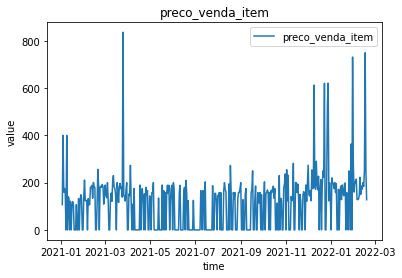

<Figure size 7200x720 with 0 Axes>

,preco_venda_item
2021-01-03,106.865691
2021-01-04,399.881389
2021-01-05,159.785068
2021-01-06,175.680798
2021-01-07,152.991004


In [ ]:
plt.plot(dfz['preco_venda_item'])
plt.title('preco_venda_item')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['preco_venda_item'], loc='upper right')
plt.figure(figsize=(100,10))
plt.show()
dfz.head()

In [ ]:
              """Data preprocessing"""
# split a univariate sequence into samples
def split_sequence(sequence):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + w
		out_end_ix = end_ix + p_w
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
raw_seq = list(dfz['preco_venda_item'])

# split into samples
batch_sample, batch_label = split_sequence(raw_seq)

# summarize the data
# for i in range(5):
# 	print(X[i], Y[i])
  
# 2. reshape from [samples, timesteps] into [samples, timesteps, features]


In [ ]:

# need to convert batch into 3D tensor of the form [batch_size, input_seq_len, n_features]
batch_sample = batch_sample.reshape((batch_sample.shape[0], batch_sample.shape[1], n_features))

In [ ]:
              """Generate model for predictor"""
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, w, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))

# Summarize model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 59, 32)            96        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 32)            2080      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 40)                1

In [ ]:
'''configure model'''
model.compile(optimizer='adam', 
              loss='mean_absolute_error')

# sgd = keras.optimizers.SGD(lr=learning_rate, 
#                          decay=1e-6, 
#                          momentum=0.9, 
#                          nesterov=True)
# model.compile(optimizer='sgd', 
#               loss='mean_absolute_error', 
#               metrics=['accuracy'])

In [ ]:
'''Training'''
model_fit = model.fit(batch_sample,
                      batch_label,
                      epochs=epochs,
                      verbose=1)

Epoch 1/30
11/11 [==============================] - 1s 4ms/step - loss: 113.1519
Epoch 2/30
11/11 [==============================] - 0s 4ms/step - loss: 99.0276
Epoch 3/30
11/11 [==============================] - 0s 4ms/step - loss: 97.7322
Epoch 4/30
11/11 [==============================] - 0s 3ms/step - loss: 97.2906
Epoch 5/30
11/11 [==============================] - 0s 3ms/step - loss: 95.8610
Epoch 6/30
11/11 [==============================] - 0s 3ms/step - loss: 95.4857
Epoch 7/30
11/11 [==============================] - 0s 4ms/step - loss: 93.7845
Epoch 8/30
11/11 [==============================] - 0s 4ms/step - loss: 93.4971
Epoch 9/30
11/11 [==============================] - 0s 3ms/step - loss: 89.3557
Epoch 10/30
11/11 [==============================] - 0s 3ms/step - loss: 90.2069
Epoch 11/30
11/11 [==============================] - 0s 3ms/step - loss: 91.7707
Epoch 12/30
11/11 [==============================] - 0s 3ms/step - loss: 89.1078
Epoch 13/30
11/11 [=================

In [ ]:
import random
"""Testing with random interval(DeepAnT)"""
# Set number of test sequences 
n_test_seq = 1

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * w - n_test_seq * p_w)
    raw_test_seq = np.array(raw_seq[ran_ix:ran_ix + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+w],
        seq_y = raw_seq[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
    return np.array(batch_test_seq), np.array(batch_test_label)

batch_test_seq, batch_test_label = generate_test_batch(list(dfz['preco_venda_item']), n_test_seq)
batch_test_seq = batch_test_seq.reshape((batch_test_seq.shape[0], w, n_features))
batch_test_label = batch_test_label.reshape((batch_test_label.shape[0], p_w))

# Returns the loss value & metrics values for the model in test mode
model.evaluate(x=batch_test_seq,
               y=batch_test_label,
               verbose=1) 


1/1 [==============================] - 0s 125ms/step - loss: 87.2601


87.26009368896484

In [ ]:
"""Save Weights (DeepAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('sinwave_DeepAnT_1.h5')  

In [ ]:
"""Predicting random intervals (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('sinwave_DeepAnT_1.h5')
          
# Sample a portion of the raw_seq randomly
# 1. Choose 
ran_ix = random.randint(1,len(raw_seq) - w - p_w)
input_seq = np.array(raw_seq[ran_ix : ran_ix + w])
target_seq = np.array(raw_seq[ran_ix + w : ran_ix + w + p_w])
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
yhat = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(yhat)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

1/1 [==============================] - 0s 104ms/step
[[ 8.43347   13.024177  14.358879  18.621294  11.037284  22.260473
   4.5699735 18.257372  15.402877  12.814025 ]]
[  0.         145.99070982 146.01661566 157.98385256   0.
 158.06135709   0.           0.           0.         166.9205186 ]


In [ ]:
"""Predicting future sequence (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('sinwave_DeepAnT_1.h5')
          

raw_seq = list(dfz['preco_venda_item'])
endix = len(raw_seq) - w - p_w
input_seq = np.array(raw_seq[endix:endix+w])
target_seq = np.array(raw_seq[endix+w:endix+w+p_w]) 
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
predicted_seq = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(predicted_seq)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

1/1 [==============================] - 0s 91ms/step
[[149.32391 117.85186 153.28235 116.01989 135.52876 141.49788 155.61736
  170.63492 153.6807  142.4543 ]]
[222.55485222 150.04661173 185.40193934 172.20534844 199.88666065
 183.91050781 252.14852916 749.50732492 247.89280826 127.89358292]


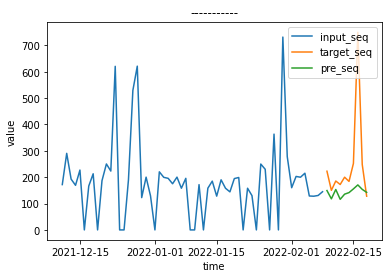

<Figure size 7200x720 with 0 Axes>

In [ ]:
'''Visualization of predicted time series'''
in_seq = dfz['preco_venda_item'][endix:endix+w]

tar_seq = dfz['preco_venda_item'][endix+w:endix+w+p_w]
predicted_seq = predicted_seq.reshape((p_w))
d = {'time': dfz['preco_venda_item'][endix+w:endix+w+p_w], 'values': predicted_seq}
df_sine_pre = pd.DataFrame(data=d)
pre_seq = df_sine_pre['values']

plt.plot(in_seq)
plt.plot(tar_seq)
plt.plot(pre_seq)
plt.title('-----------')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['input_seq', 'target_seq', 'pre_seq'], loc='upper right')
axes = plt.gca()
# axes.set_xlim([endix,endix+w+p_w])
fig_predict = plt.figure(figsize=(100,10))
fig_predict.savefig('predicted_sequence.png')
plt.show()

In [ ]:
anomaly_detector(pre_seq, tar_seq)

True

In [ ]:
# dfz4 = df_zeros(df, id_seller='vendedor4')

In [ ]:
# Shallow CNN version  
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# define input sequence
raw_seq = [-5, 5, -10, 10, -15, 15, -20, 20, -25]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mean_absolute_error')
# fit model
model.fit(X, y, epochs=500, verbose=1)
# demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=1)
print(yhat)

Epoch 1/500
1/1 [==============================] - 0s 352ms/step - loss: 18.2203
Epoch 2/500
1/1 [==============================] - 0s 9ms/step - loss: 18.1425
Epoch 3/500
1/1 [==============================] - 0s 8ms/step - loss: 18.0708
Epoch 4/500
1/1 [==============================] - 0s 8ms/step - loss: 18.0107
Epoch 5/500
1/1 [==============================] - 0s 8ms/step - loss: 17.9677
Epoch 6/500
1/1 [==============================] - 0s 8ms/step - loss: 17.9152
Epoch 7/500
1/1 [==============================] - 0s 8ms/step - loss: 17.8662
Epoch 8/500
1/1 [==============================] - 0s 5ms/step - loss: 17.8204
Epoch 9/500
1/1 [==============================] - 0s 5ms/step - loss: 17.7611
Epoch 10/500
1/1 [==============================] - 0s 5ms/step - loss: 17.7036
Epoch 11/500
1/1 [==============================] - 0s 5ms/step - loss: 17.6491
Epoch 12/500
1/1 [==============================] - 0s 5ms/step - loss: 17.5949
Epoch 13/500
1/1 [=============================

In [ ]:
"""Save Weights (ShallowAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('sinwave_ShallowAnT_1.h5')  